# Описание задачи

Есть датасет для ранжирования intern_task.csv:

1. query_id - айдишник поисковой сессии.

2. фичи релевантности по запросу

3. rank - оценка релевантности

Задача:

1. Подготовить и проверить датасет
2. Натренировать на любом фрейемворке модель, которая будетт ранжировать документы по их фичам внутри одной сессии (query_id) (по вектору фичей предсказываеть ранк документа)
3. Посчитать метрики ранжирования для своей модели (ndcg_5 как минимум)
4. оформить решение и выложить на гит

In [1]:
!pip install xgboost

# Разведочный анализ

## Импорт библиотек

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style

from joblib import dump, load

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, GroupKFold, GridSearchCV



from sklearn.linear_model import LinearRegression
from xgboost import XGBClassifier
import xgboost as xgb

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, top_k_accuracy_score 

In [3]:
# Загрузим датасет
data = pd.read_csv('intern_task.csv')

In [4]:
data.head()

,rank,query_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143
0,0,10,1.0,0.0,1.0,3.0,3.0,0.333333,0.0,0.333333,...,0.0,0.000000,0.454545,0.890238,8.655534,1.000000,0.077778,0.002222,1.0,0.333333
1,1,10,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,...,0.0,0.000000,0.000000,0.773976,23.130514,0.000000,0.027826,0.000430,44.0,14.666667
2,0,10,3.0,0.0,2.0,0.0,3.0,1.000000,0.0,0.666667,...,0.0,0.000000,0.000000,0.918308,13.351339,0.000000,0.014925,0.000104,22.0,7.333333
3,1,10,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,...,0.0,0.000000,0.000000,0.975355,18.240926,0.000000,0.053140,0.000255,8.0,2.666667
4,2,10,3.0,0.0,3.0,1.0,3.0,1.000000,0.0,1.000000,...,273.0,79.670665,0.200000,0.990119,31.786048,0.333333,0.046512,0.000307,24.0,8.000000


Видим наш датасет. В нем есть наша целевая переменная - rank, также видим сесии - query_id, остальное наши фичи

In [5]:
data['rank'].unique()

array([0, 1, 2, 4, 3], dtype=int64)

Оценки релевантности находтся в диапазоне от 0 до 4

In [6]:
data['query_id'].unique()

array([   10,    25,    40, ..., 29965, 29980, 29995], dtype=int64)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235258 entries, 0 to 235257
Columns: 146 entries, rank to feature_143
dtypes: float64(140), int64(6)
memory usage: 262.1 MB


Все данные являются числовыми - это float и int. Пропущенных значений нет.

In [8]:
# Проверим датасет на дубликаты
data.duplicated().sum()

0

In [9]:
# Посмотрим на описательную статистику
data.describe()

,rank,query_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143
count,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,...,2.352580e+05,2.352580e+05,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000
mean,0.677869,14828.413401,1.911960,0.206233,1.189847,0.550272,1.960082,0.803964,0.097557,0.541174,...,4.763432e+02,1.046698e+04,0.070299,0.740710,11.067947,0.281747,0.027033,0.000269,22.457910,9.560379
std,0.830033,8193.945170,1.237374,0.579089,1.037233,0.790947,1.203534,0.339955,0.266035,0.419973,...,1.954840e+04,2.649584e+06,0.100721,0.352800,15.336861,0.392089,0.033351,0.002088,63.708018,14.347378
min,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,8215.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.666667,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000,0.620522,0.000000,0.000000,0.006703,0.000000,4.000000,2.000000
50%,0.000000,14935.000000,2.000000,0.000000,1.000000,0.000000,2.000000,1.000000,0.000000,0.500000,...,0.000000e+00,0.000000e+00,0.000000,0.926779,9.448900,0.000000,0.017761,0.000008,12.000000,5.500000
75%,1.000000,21580.000000,3.000000,0.000000,2.000000,1.000000,3.000000,1.000000,0.000000,1.000000,...,1.000000e+00,4.000000e-01,0.142857,0.999613,16.146733,0.500000,0.034954,0.000109,28.000000,12.000000
max,4.000000,29995.000000,31.000000,18.000000,27.000000,9.000000,31.000000,1.000000,1.000000,1.000000,...,1.731553e+06,8.000000e+08,0.818182,1.000000,2506.799764,1.000000,0.711261,0.250000,15074.000000,1552.000000


Видим, что некоторые фичи имеют разброс по стандартному отклонению, а также по среднему значению, а это значит надо будет провести нормализацию\стандартизацию для обеспечения стабильного обучения модлей.

In [10]:
#Уникальные значения
data.nunique()

rank               5
query_id        2000
feature_0         16
feature_1         10
feature_2         15
               ...  
feature_139       29
feature_140    41864
feature_141     4703
feature_142      529
feature_143     1431
Length: 146, dtype: int64

## Визуализация

Для начала просмотрим на то, какое распределение имеют наши фичи, далее посмотрим на выбросы, а также изучим момент, связанный с корреляцией признаков.

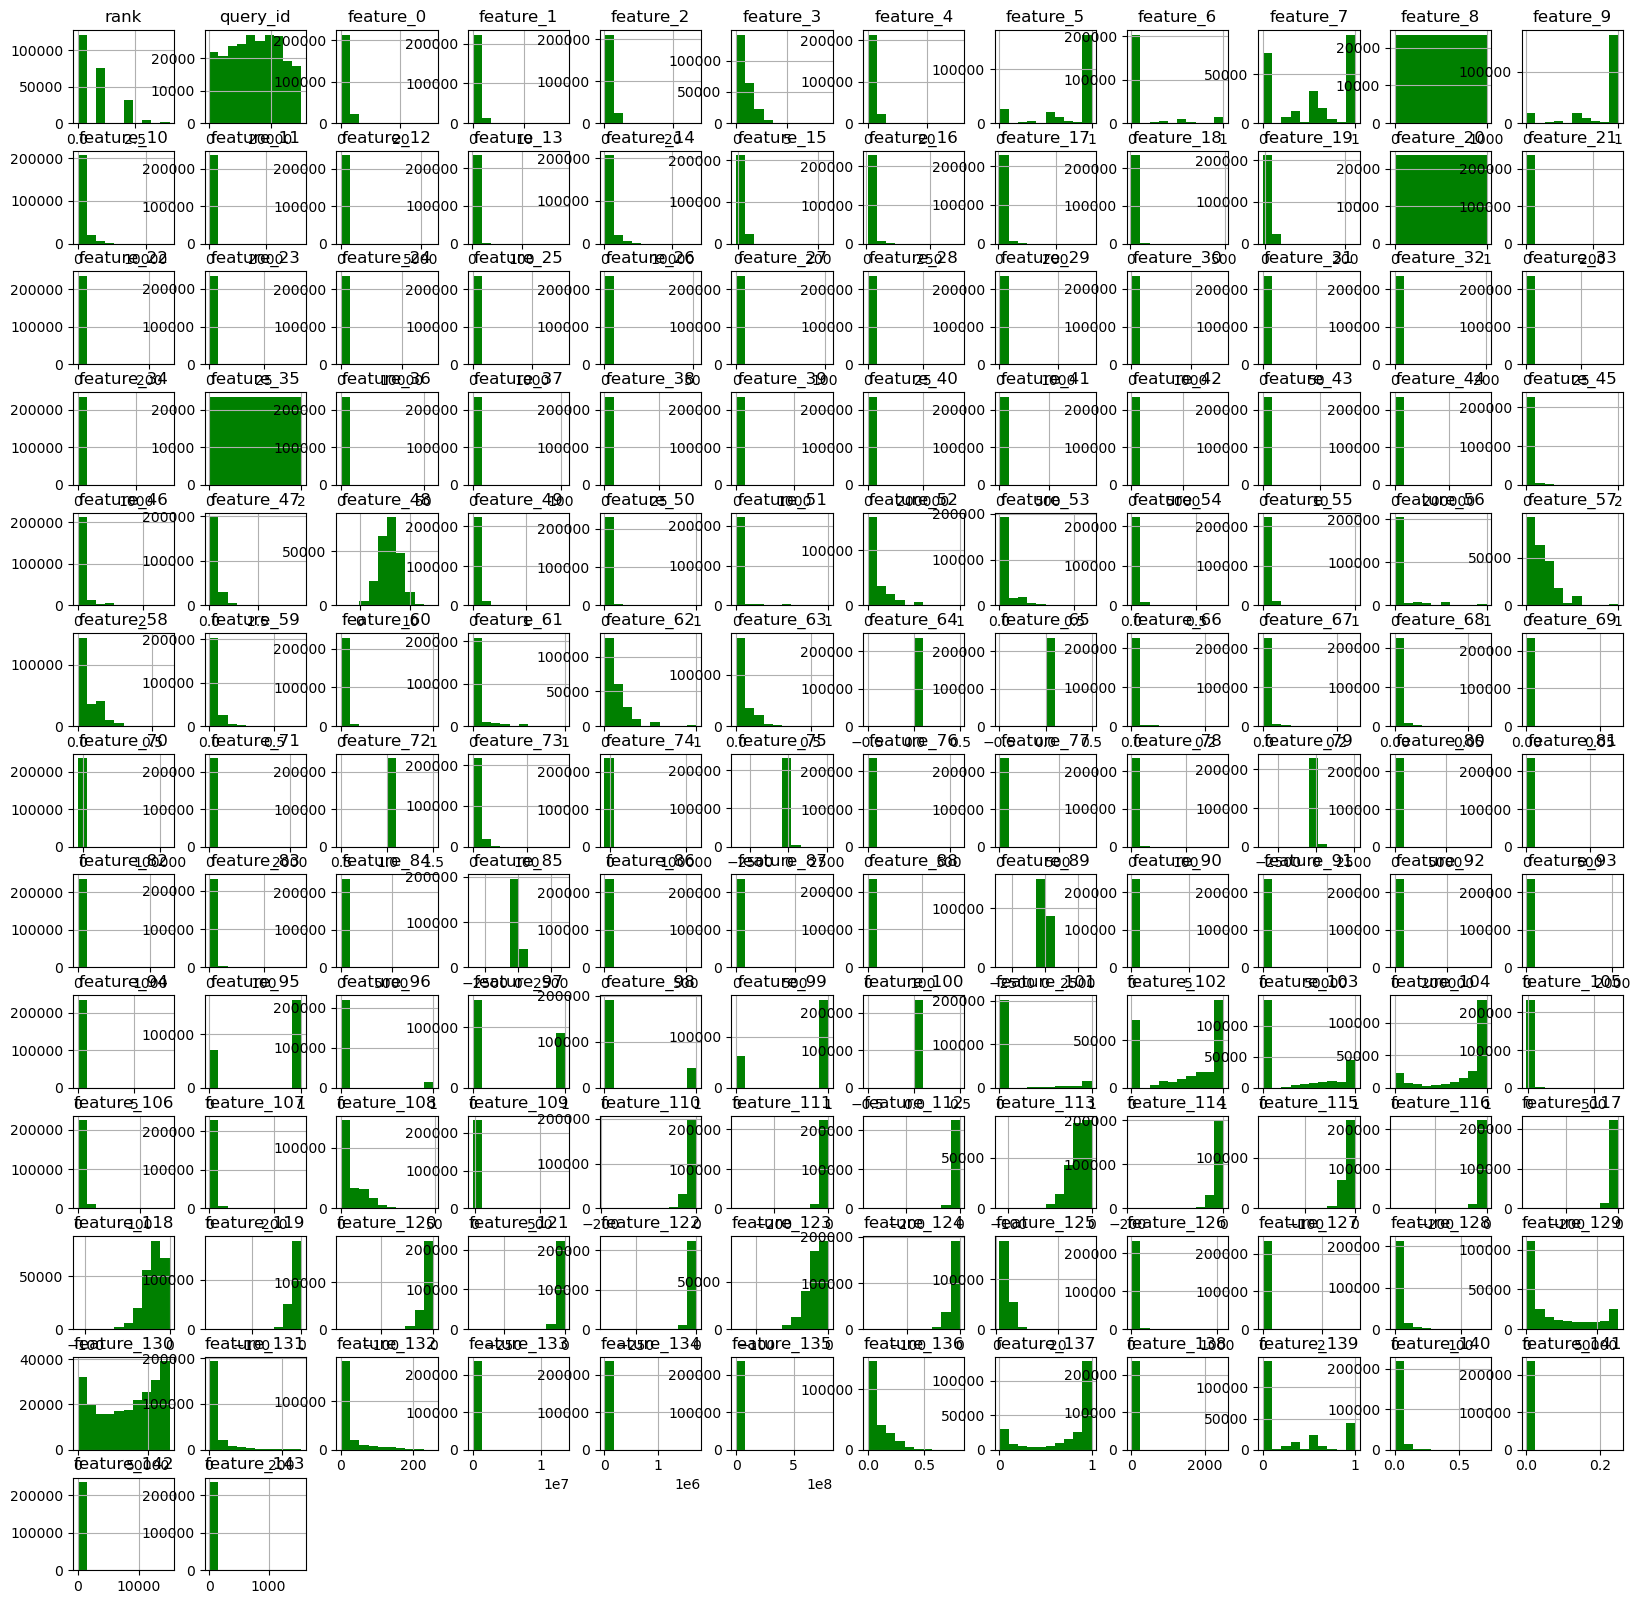

In [11]:
#Для того, чтобы посмотреть на то, как распределены наши данные, построим гистограммы распределения
import matplotlib.pyplot as plt
data.hist(figsize = (20,20), color = "g")
plt.show()

In [12]:
#напишем функцию для отрисовки боксов с усами для выявления выбросов

def box(df):

  '''Функция отрисовки боксов с усами.
  На входе:
  df - датафрейм
  На выходе:
  боксы с усами по признакам датафрейма'''

  plt.figure(figsize = (20, 20))
  plt.suptitle('боксы с усами', y = 0.9, fontsize = 30)
  plt.boxplot(pd.DataFrame(df), labels=df.columns, patch_artist = True, meanline = True, vert = False, boxprops = dict(facecolor = 'g', color = 'g'),medianprops = dict(color = 'lime'), whiskerprops = dict(color="g"), capprops = dict(color = "black"), flierprops = dict(color = "y", markeredgecolor = "maroon"))
  plt.show()

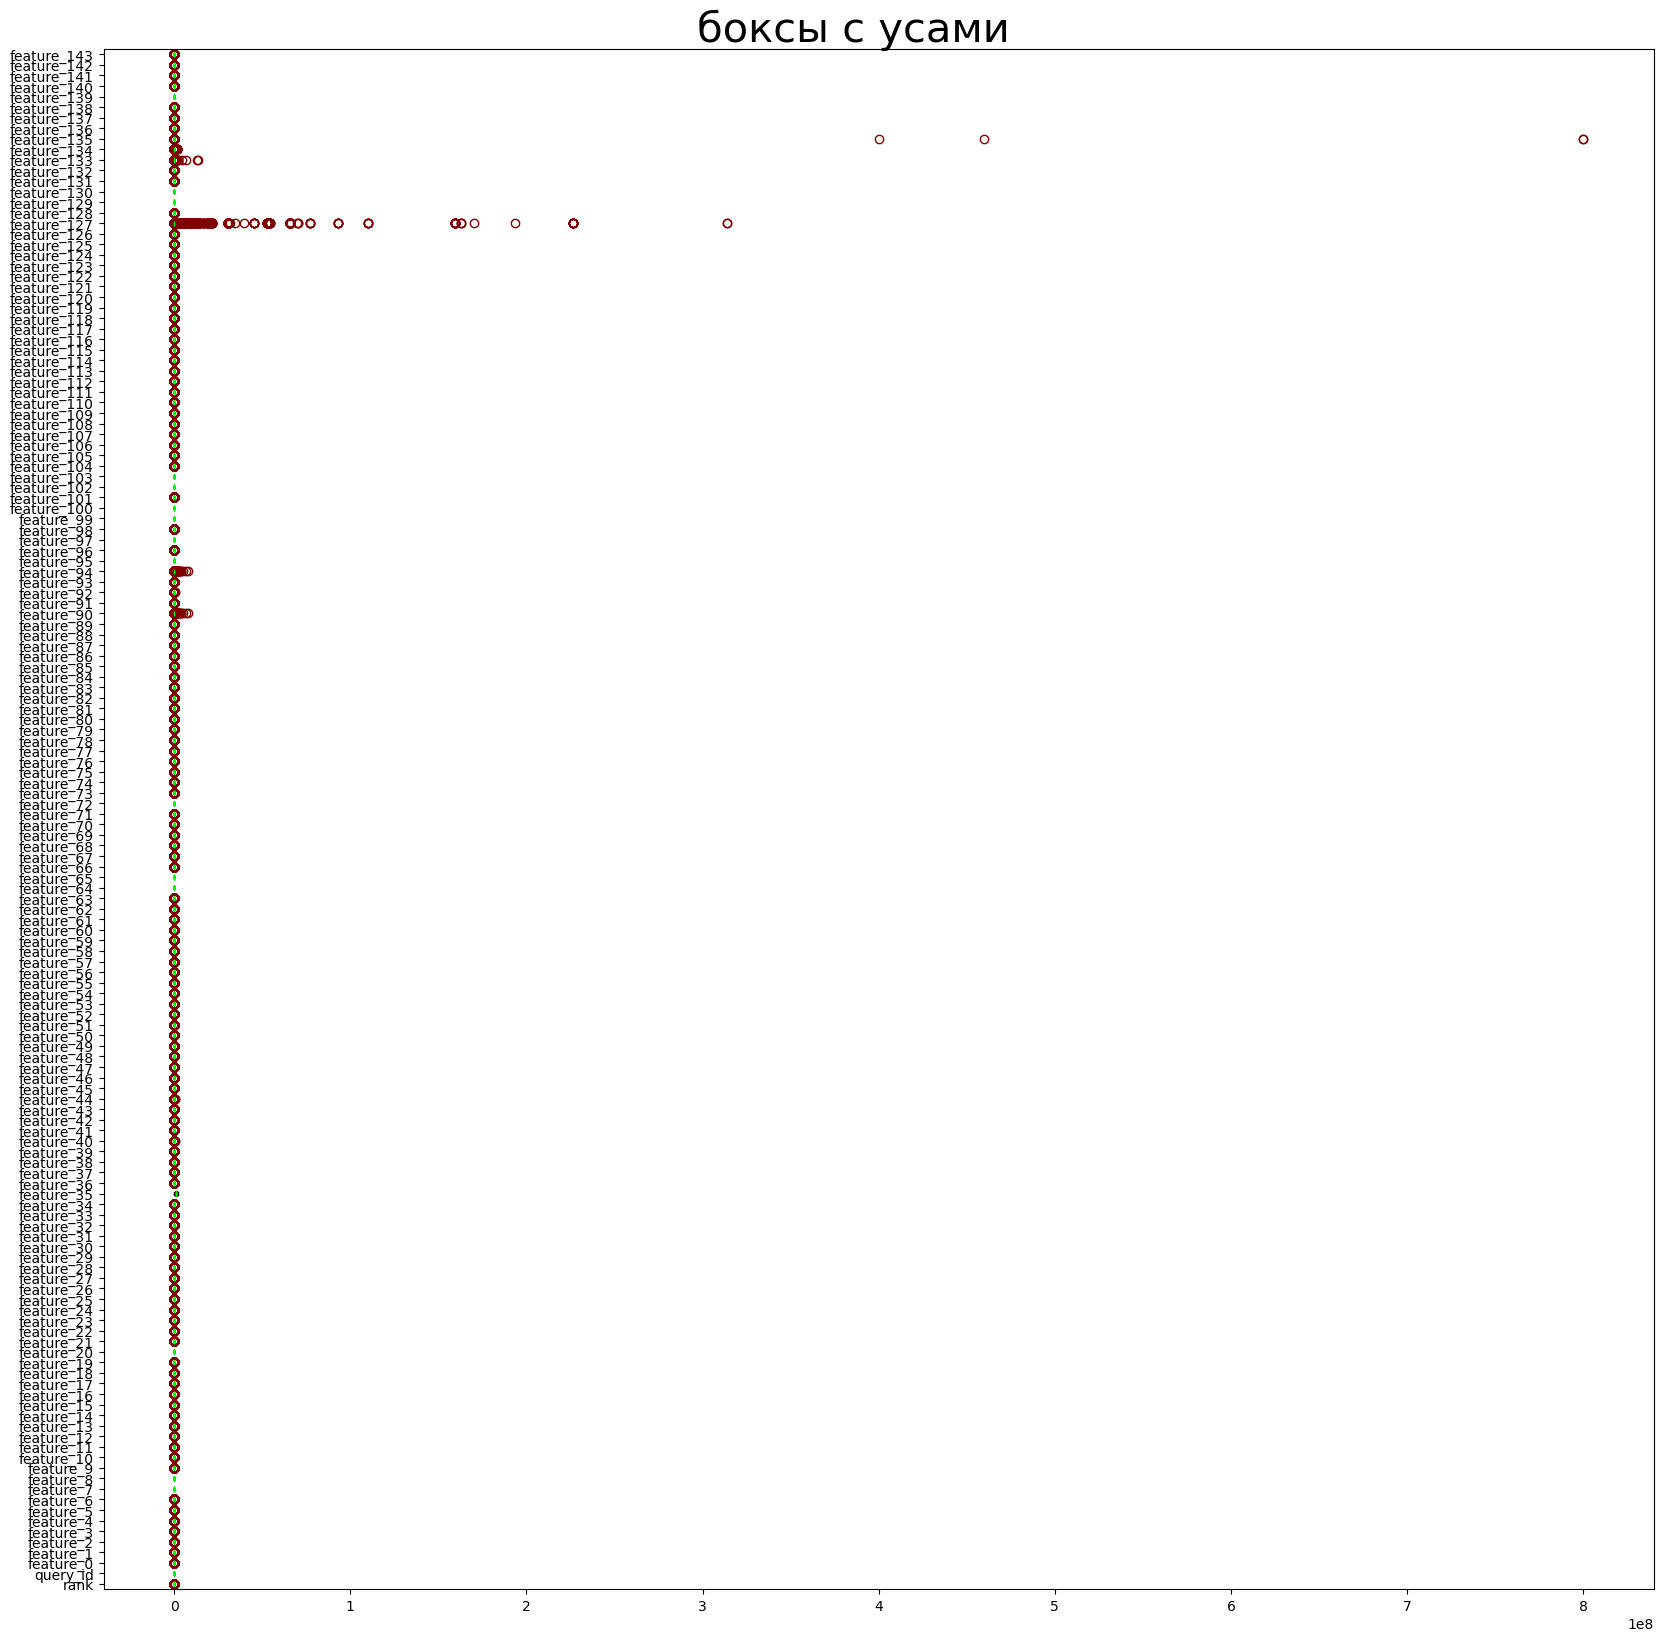

In [13]:
box(data)

Наблюдаем наличие выбросов в фичах 90, 94, 127, 133, 134. В задачах ранжирования, особенно если выбросы могут существенно искажать порядок ранжирования, удаление выбросов может быть целесообразным. Попробуем провести эксперименты с обеими вариантами (с удалением и без удаления выбросов) и сравнить результаты моделирования, чтобы принять более обоснованное решение.

In [14]:
#Для определения взаимосвязи между признаками построим корреляционную матрицу.
data.corr()

,rank,query_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143
rank,1.000000,0.074057,-0.034239,0.097110,0.177743,0.120893,-0.029628,0.078850,0.109373,0.231477,...,-0.002400,-0.000130,0.135449,0.098959,0.121585,0.149626,0.155181,0.001207,0.017734,0.087033
query_id,0.074057,1.000000,-0.040320,-0.019186,-0.004201,0.020878,-0.036808,-0.005223,-0.007782,0.032868,...,-0.005803,0.001679,0.026565,0.000980,0.006226,0.049949,0.034563,-0.005864,0.001791,0.011541
feature_0,-0.034239,-0.040320,1.000000,0.131044,0.560199,0.155114,0.979494,0.590972,0.008262,0.176838,...,-0.020799,0.000721,0.083786,0.437207,0.335744,-0.111323,-0.047251,0.026149,0.309202,0.162987
feature_1,0.097110,-0.019186,0.131044,1.000000,0.208730,0.196483,0.142909,0.119076,0.890659,0.159313,...,-0.007154,-0.001405,0.178257,0.105447,0.134541,0.134350,0.105877,0.016457,0.114352,0.182067
feature_2,0.177743,-0.004201,0.560199,0.208730,1.000000,0.306295,0.538310,0.482131,0.124211,0.768004,...,-0.020478,0.000422,0.240712,0.435177,0.621490,0.111337,0.189865,0.037717,0.235129,0.224031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
feature_139,0.149626,0.049949,-0.111323,0.134350,0.111337,0.833796,-0.067245,0.139908,0.195519,0.287774,...,-0.009599,-0.000954,0.843068,0.179221,0.098203,1.000000,0.336723,0.006884,0.020168,0.145930
feature_140,0.155181,0.034563,-0.047251,0.105877,0.189865,0.225540,-0.013788,0.191179,0.149277,0.355177,...,-0.010228,0.000567,0.285388,0.216457,0.189261,0.336723,1.000000,0.169442,0.092988,0.262832
feature_141,0.001207,-0.005864,0.026149,0.016457,0.037717,0.036037,0.029016,-0.003988,0.003916,0.007805,...,-0.002304,-0.000052,0.037421,-0.020480,0.044194,0.006884,0.169442,1.000000,0.072902,0.097090
feature_142,0.017734,0.001791,0.309202,0.114352,0.235129,0.084797,0.305479,0.143931,0.076314,0.095519,...,-0.006998,-0.000398,0.075562,0.086268,0.307781,0.020168,0.092988,0.072902,1.000000,0.570354


D:\Users\irina\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


<Axes: >

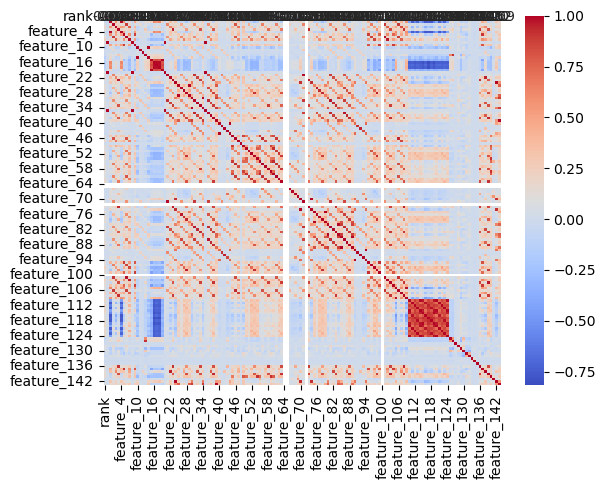

In [15]:
# Тепловая карта
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt=".2f")

Здесь видим две странные области (красные, где есть силььно коррелирующие признаки). Рассмотрим их подробнее

<Axes: >

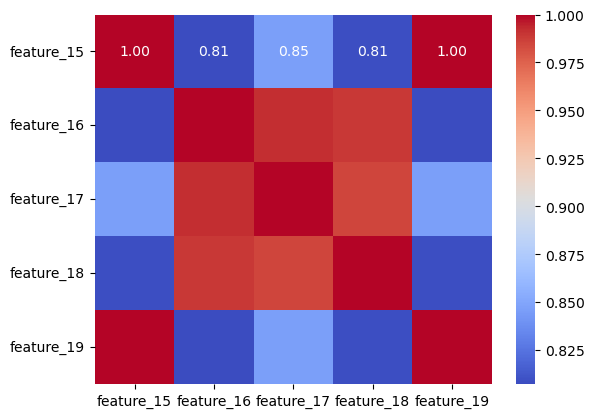

In [16]:
sns.heatmap(data[['feature_15', 'feature_16', 'feature_17', 'feature_18','feature_19']].corr(), annot = True, cmap='coolwarm', fmt=".2f")

Фичи 16, 17, 18 сильно коррелируют друг с другом.

<Axes: >

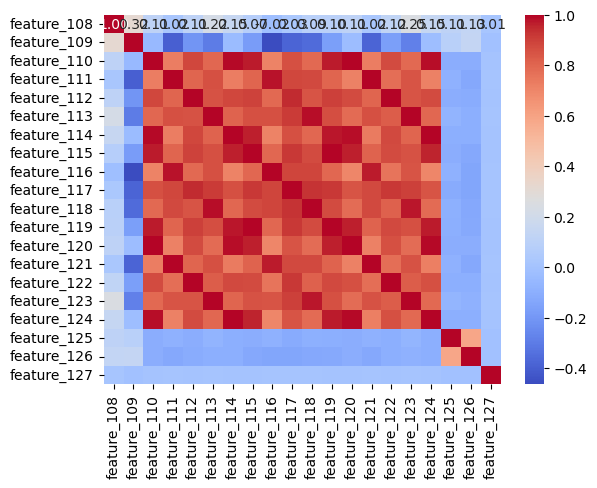

In [17]:
sns.heatmap(data[['feature_108', 'feature_109', 'feature_110', 'feature_111', 'feature_112', 'feature_113',
                  'feature_114', 'feature_115', 'feature_116', 'feature_117', 
                  'feature_118', 'feature_119', 'feature_120', 'feature_121', 
                  'feature_122', 'feature_123','feature_124', 'feature_125', 'feature_126',
                  'feature_127']].corr(), annot = True, cmap='coolwarm', fmt=".2f")

Признаки 110, 114, 115, 119, 120 и 124 очень сильно коррелируют друг с другом. 

Признаки 111, 116 и 121 тоже имеют сильную корреляцию.

Признаки 113, 118 и 123

А также признаки 112 и 122

D:\Users\irina\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


<Axes: >

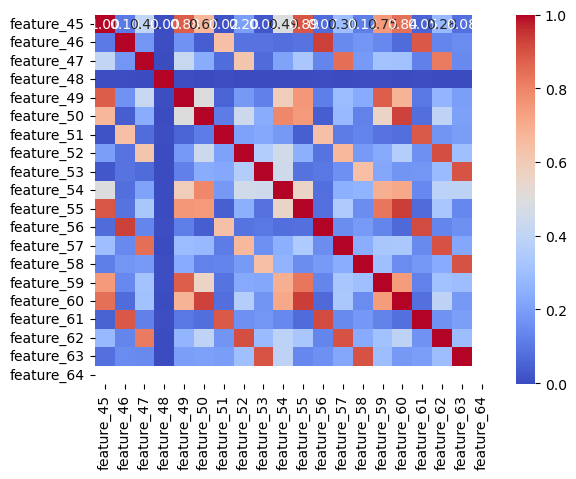

In [18]:
sns.heatmap(data[['feature_45', 'feature_46', 'feature_47', 'feature_48', 'feature_49', 'feature_50',
                  'feature_51', 'feature_52', 'feature_53', 'feature_54', 
                  'feature_55', 'feature_56', 'feature_57', 'feature_58', 
                  'feature_59', 'feature_60','feature_61', 'feature_62', 'feature_63',
                  'feature_64']].corr(), annot = True, cmap='coolwarm', fmt=".2f")

Еще интересуют синие области, так как там сильная отрицательная корреляция.

# Предобработка данных

## Категориальные признаки

Имеем один категориальный признак - query_id. Будем его кодировать с помощью LabelEncoder

In [19]:
encoder = LabelEncoder()
label = ['query_id']
encoder.fit(data[label].values)

# Сохраним кодировку 
dump(encoder, 'encoder.joblin')

D:\Users\irina\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['encoder.joblin']

In [20]:
data['query_id'] = encoder.transform(data['query_id'])

In [21]:
data

,rank,query_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143
0,0,0,1.0,0.0,1.0,3.0,3.0,0.333333,0.0,0.333333,...,0.0,0.000000,0.454545,0.890238,8.655534,1.000000,0.077778,0.002222,1.0,0.333333
1,1,0,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,...,0.0,0.000000,0.000000,0.773976,23.130514,0.000000,0.027826,0.000430,44.0,14.666667
2,0,0,3.0,0.0,2.0,0.0,3.0,1.000000,0.0,0.666667,...,0.0,0.000000,0.000000,0.918308,13.351339,0.000000,0.014925,0.000104,22.0,7.333333
3,1,0,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,...,0.0,0.000000,0.000000,0.975355,18.240926,0.000000,0.053140,0.000255,8.0,2.666667
4,2,0,3.0,0.0,3.0,1.0,3.0,1.000000,0.0,1.000000,...,273.0,79.670665,0.200000,0.990119,31.786048,0.333333,0.046512,0.000307,24.0,8.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235253,2,1999,1.0,0.0,0.0,0.0,1.0,0.500000,0.0,0.000000,...,0.0,0.000000,0.000000,0.471409,0.000000,0.000000,0.001350,0.000002,3.0,1.500000
235254,2,1999,1.0,0.0,1.0,0.0,1.0,0.500000,0.0,0.500000,...,0.0,0.000000,0.000000,0.471409,39.908056,0.000000,0.004850,0.000014,9.0,4.500000
235255,1,1999,1.0,0.0,0.0,0.0,1.0,0.500000,0.0,0.000000,...,0.0,0.000000,0.000000,0.471409,0.000000,0.000000,0.001064,0.000001,1.0,0.500000
235256,2,1999,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


## Нормализация

Двумя наиболее обсуждаемыми методами масштабирования являются нормализация и стандартизация. Нормализация обычно означает масштабирование значений в диапазон [0,1].Стандартизация обычно означает, что данные масштабирования имеют среднее значение 0 и стандартное отклонение 1 (единичная дисперсия).

STANDARDSCALER: приведение к нормальному распределению

In [22]:
#Напишем функцию для скалирования и нормализации

def scal(df, scaler):

  '''Функция преобразования датасета (скалирование, нормализация и тд).
  На входе:
  df - датафрейм, который необходимо преобразовать
  scaler - метод преобразования датафрейма
  На выходе:
  data_scal - преобразованный датасет'''
  
  scaler = scaler
  scaler.fit(df)
  data_scal =  scaler.transform(df)

  #Переведем наш массив в датафрейм для просмотра статистических показателей
  data_scal = pd.DataFrame(data_scal, columns=df.columns) 
  data_scal.describe()

  return data_scal

Нормализовывать будем только фичи, так как нормализация query_id не требуется. query_id является идентификатором поисковой сессии или запроса, который представляет собой категориальный признак. Будем его кодировать. Для rank тоже нет необходимости нормализации, так как будем использовать модели, которые не требуют масштабирования признаков, например, деревья решений или ансамбли на их основе (например, LambdaMART).

In [23]:
# Приведем данные к диапазону [0, 1]
data_mm = scal(data.drop(['query_id', 'rank'], axis=1), MinMaxScaler())
data_mm.describe() 

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143
count,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,...,2.352580e+05,2.352580e+05,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000
mean,0.061676,0.011457,0.044068,0.061141,0.063228,0.803964,0.097557,0.541174,0.500000,0.834909,...,2.750960e-04,1.308372e-05,0.085920,0.740710,0.004415,0.281747,0.038007,0.001074,0.001490,0.006160
std,0.039915,0.032172,0.038416,0.087883,0.038824,0.339955,0.266035,0.419973,0.288677,0.310762,...,1.128952e-02,3.311981e-03,0.123103,0.352800,0.006118,0.392089,0.046890,0.008352,0.004226,0.009244
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.032258,0.000000,0.000000,0.000000,0.032258,0.666667,0.000000,0.000000,0.250000,0.750000,...,0.000000e+00,0.000000e+00,0.000000,0.620522,0.000000,0.000000,0.009425,0.000000,0.000265,0.001289
50%,0.064516,0.000000,0.037037,0.000000,0.064516,1.000000,0.000000,0.500000,0.500000,1.000000,...,0.000000e+00,0.000000e+00,0.000000,0.926779,0.003769,0.000000,0.024972,0.000032,0.000796,0.003544
75%,0.096774,0.000000,0.074074,0.111111,0.096774,1.000000,0.000000,1.000000,0.750000,1.000000,...,5.775163e-07,5.000000e-10,0.174603,0.999613,0.006441,0.500000,0.049144,0.000436,0.001858,0.007732
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [24]:
data_mm['rank'] = data['rank']
data_mm['query_id'] = data['query_id']
data_mm

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143,rank,query_id
0,0.032258,0.0,0.037037,0.333333,0.096774,0.333333,0.0,0.333333,0.000000,1.0,...,0.555555,0.890238,0.003453,1.000000,0.109352,0.008888,0.000066,0.000215,0,0
1,0.096774,0.0,0.111111,0.000000,0.096774,1.000000,0.0,1.000000,0.000004,1.0,...,0.000000,0.773976,0.009227,0.000000,0.039122,0.001720,0.002919,0.009450,1,0
2,0.096774,0.0,0.074074,0.000000,0.096774,1.000000,0.0,0.666667,0.000009,1.0,...,0.000000,0.918308,0.005326,0.000000,0.020984,0.000416,0.001459,0.004725,0,0
3,0.096774,0.0,0.111111,0.000000,0.096774,1.000000,0.0,1.000000,0.000013,1.0,...,0.000000,0.975355,0.007277,0.000000,0.074712,0.001020,0.000531,0.001718,1,0
4,0.096774,0.0,0.111111,0.111111,0.096774,1.000000,0.0,1.000000,0.000017,1.0,...,0.244444,0.990119,0.012680,0.333333,0.065394,0.001228,0.001592,0.005155,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235253,0.032258,0.0,0.000000,0.000000,0.032258,0.500000,0.0,0.000000,0.999983,0.5,...,0.000000,0.471409,0.000000,0.000000,0.001898,0.000008,0.000199,0.000966,2,1999
235254,0.032258,0.0,0.037037,0.000000,0.032258,0.500000,0.0,0.500000,0.999987,0.5,...,0.000000,0.471409,0.015920,0.000000,0.006819,0.000056,0.000597,0.002899,2,1999
235255,0.032258,0.0,0.000000,0.000000,0.032258,0.500000,0.0,0.000000,0.999991,0.5,...,0.000000,0.471409,0.000000,0.000000,0.001496,0.000004,0.000066,0.000322,1,1999
235256,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.999996,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2,1999


D:\Users\irina\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


<Axes: >

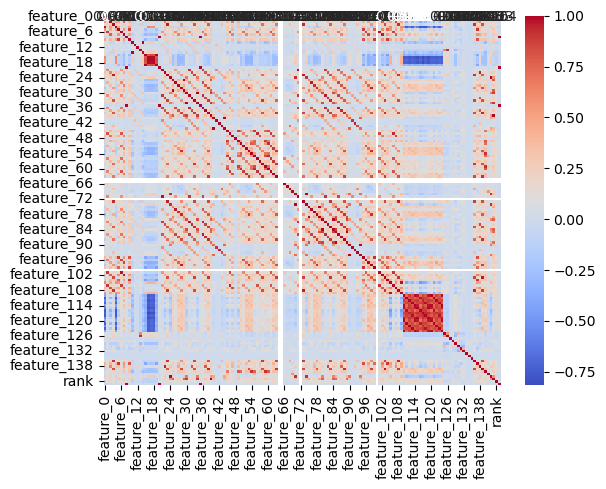

In [25]:
sns.heatmap(data_mm.corr(), annot = True, cmap='coolwarm', fmt=".2f")

# Удаление коррелирующих признаков

In [26]:
# Выпишем в отдельный список фичи для удаления
del_features  = ['feature_16', 'feature_17', 'feature_18', 'feature_48', 'feature_110', 'feature_111', 'feature_112',
                 'feature_113','feature_114','feature_115', 'feature_116', 'feature_117', 'feature_118', 
                 'feature_119', 'feature_120', 'feature_121', 'feature_122', 'feature_123', 'feature_124']

In [27]:
data_corr = data_mm.drop(del_features, axis=1)

In [28]:
data_corr

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143,rank,query_id
0,0.032258,0.0,0.037037,0.333333,0.096774,0.333333,0.0,0.333333,0.000000,1.0,...,0.555555,0.890238,0.003453,1.000000,0.109352,0.008888,0.000066,0.000215,0,0
1,0.096774,0.0,0.111111,0.000000,0.096774,1.000000,0.0,1.000000,0.000004,1.0,...,0.000000,0.773976,0.009227,0.000000,0.039122,0.001720,0.002919,0.009450,1,0
2,0.096774,0.0,0.074074,0.000000,0.096774,1.000000,0.0,0.666667,0.000009,1.0,...,0.000000,0.918308,0.005326,0.000000,0.020984,0.000416,0.001459,0.004725,0,0
3,0.096774,0.0,0.111111,0.000000,0.096774,1.000000,0.0,1.000000,0.000013,1.0,...,0.000000,0.975355,0.007277,0.000000,0.074712,0.001020,0.000531,0.001718,1,0
4,0.096774,0.0,0.111111,0.111111,0.096774,1.000000,0.0,1.000000,0.000017,1.0,...,0.244444,0.990119,0.012680,0.333333,0.065394,0.001228,0.001592,0.005155,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235253,0.032258,0.0,0.000000,0.000000,0.032258,0.500000,0.0,0.000000,0.999983,0.5,...,0.000000,0.471409,0.000000,0.000000,0.001898,0.000008,0.000199,0.000966,2,1999
235254,0.032258,0.0,0.037037,0.000000,0.032258,0.500000,0.0,0.500000,0.999987,0.5,...,0.000000,0.471409,0.015920,0.000000,0.006819,0.000056,0.000597,0.002899,2,1999
235255,0.032258,0.0,0.000000,0.000000,0.032258,0.500000,0.0,0.000000,0.999991,0.5,...,0.000000,0.471409,0.000000,0.000000,0.001496,0.000004,0.000066,0.000322,1,1999
235256,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.999996,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2,1999


D:\Users\irina\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


<Axes: >

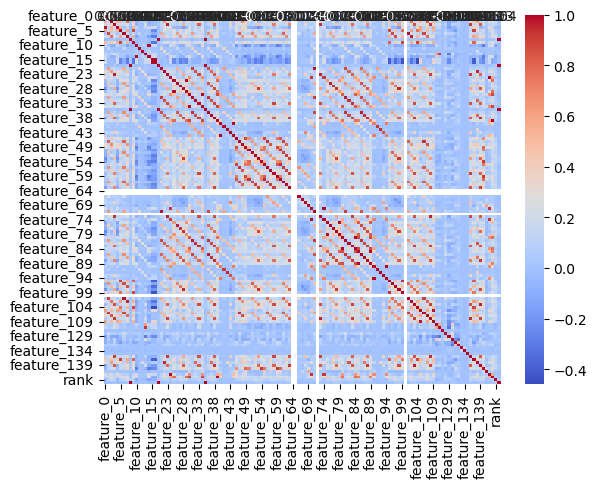

In [29]:
sns.heatmap(data_corr.corr(), annot = True, cmap='coolwarm', fmt=".2f")

С корреляцией уже лучше, но все равно видим яркие вкрапления сильно коррелирующих признаков.

# Удаление выбросов

Займемся выбросами. Используем межквартильный размах IQR

In [30]:
def iqr(data, col):

  '''Функция очистки датасета от выбросов с помощью подхода iqr
  На входе:
  data - датасет, который надо очистить от выбросов
  col - колонки, в которых присутствуют выбросы
  На выходе:
  data_iqr - датасет без выбросов'''

  for i in col:
    Q1 = data[i].quantile(0.25)
    Q3 = data[i].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    data.loc[data[i] < lower, i] = np.nan
    data.loc[data[i] > upper, i] = np.nan

  #Удаляем строки c выбросами
  data_iqr = data.dropna(axis=0)
  return data_iqr

In [31]:
# Выпишем фичи для удобства
data_corr.columns.values.tolist()

['feature_0',
 'feature_1',
 'feature_2',
 'feature_3',
 'feature_4',
 'feature_5',
 'feature_6',
 'feature_7',
 'feature_8',
 'feature_9',
 'feature_10',
 'feature_11',
 'feature_12',
 'feature_13',
 'feature_14',
 'feature_15',
 'feature_19',
 'feature_20',
 'feature_21',
 'feature_22',
 'feature_23',
 'feature_24',
 'feature_25',
 'feature_26',
 'feature_27',
 'feature_28',
 'feature_29',
 'feature_30',
 'feature_31',
 'feature_32',
 'feature_33',
 'feature_34',
 'feature_35',
 'feature_36',
 'feature_37',
 'feature_38',
 'feature_39',
 'feature_40',
 'feature_41',
 'feature_42',
 'feature_43',
 'feature_44',
 'feature_45',
 'feature_46',
 'feature_47',
 'feature_49',
 'feature_50',
 'feature_51',
 'feature_52',
 'feature_53',
 'feature_54',
 'feature_55',
 'feature_56',
 'feature_57',
 'feature_58',
 'feature_59',
 'feature_60',
 'feature_61',
 'feature_62',
 'feature_63',
 'feature_64',
 'feature_65',
 'feature_66',
 'feature_67',
 'feature_68',
 'feature_69',
 'feature_70',
 'fea

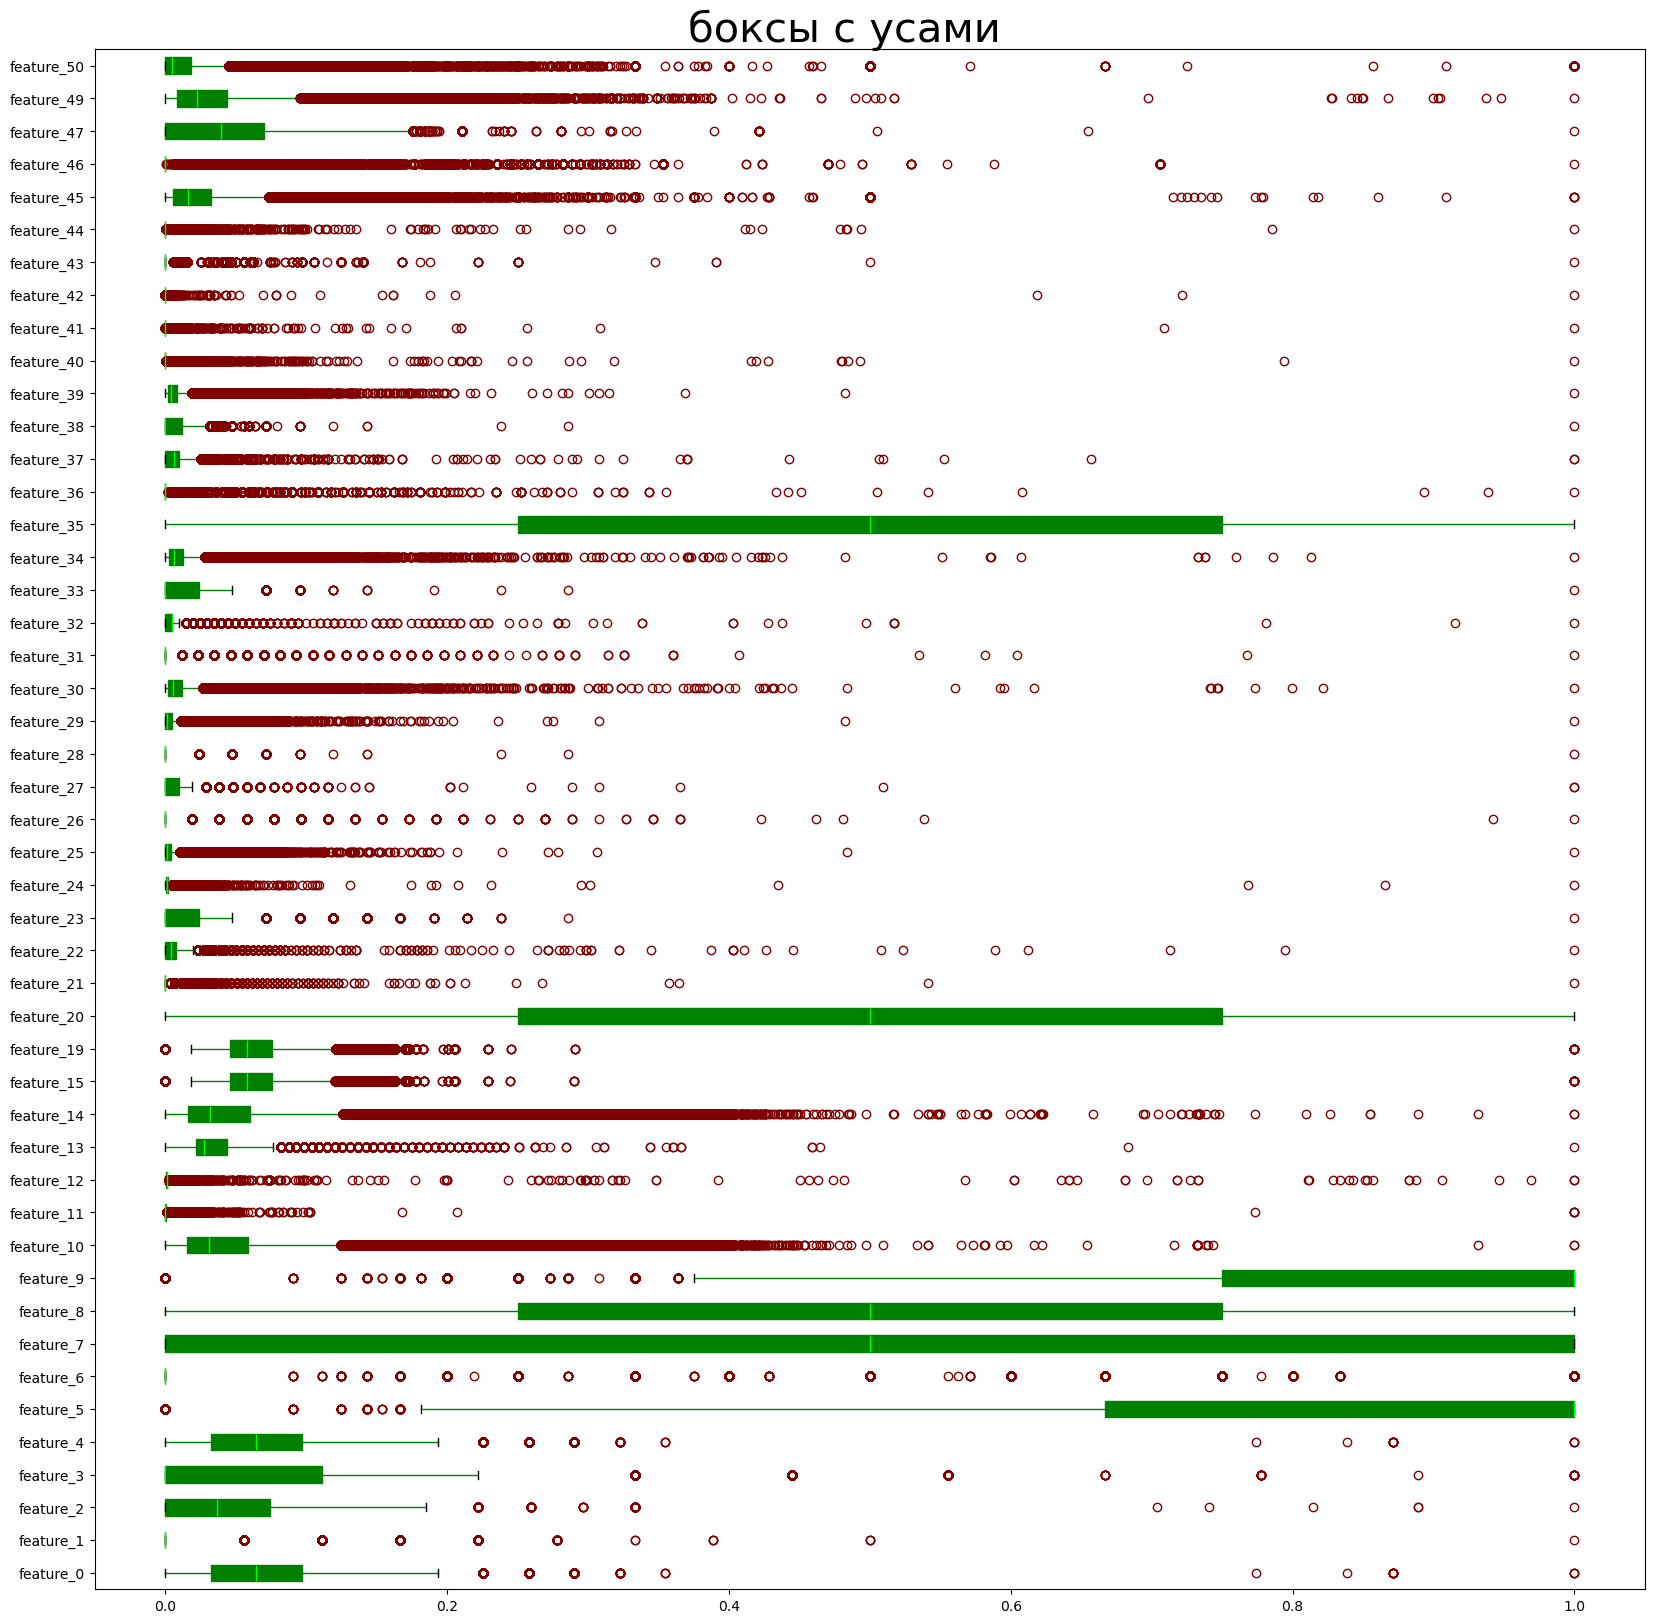

In [32]:
# еше раз взглянем на выбросы по блокам по 50 фичей для наглядности

box(data_corr[['feature_0', 'feature_1', 
               'feature_2', 
               'feature_3', 
               'feature_4', 
               'feature_5',
 'feature_6',
 'feature_7',
 'feature_8',
 'feature_9',
 'feature_10',
 'feature_11',
 'feature_12',
 'feature_13',
 'feature_14',
 'feature_15',
 'feature_19',
 'feature_20',
 'feature_21',
 'feature_22',
 'feature_23',
 'feature_24',
 'feature_25',
 'feature_26',
 'feature_27',
 'feature_28',
 'feature_29',
 'feature_30',
 'feature_31',
 'feature_32',
 'feature_33',
 'feature_34',
 'feature_35',
 'feature_36',
 'feature_37',
 'feature_38',
 'feature_39',
 'feature_40',
 'feature_41',
 'feature_42',
 'feature_43',
 'feature_44',
 'feature_45',
 'feature_46',
 'feature_47',
 'feature_49',
 'feature_50',]])

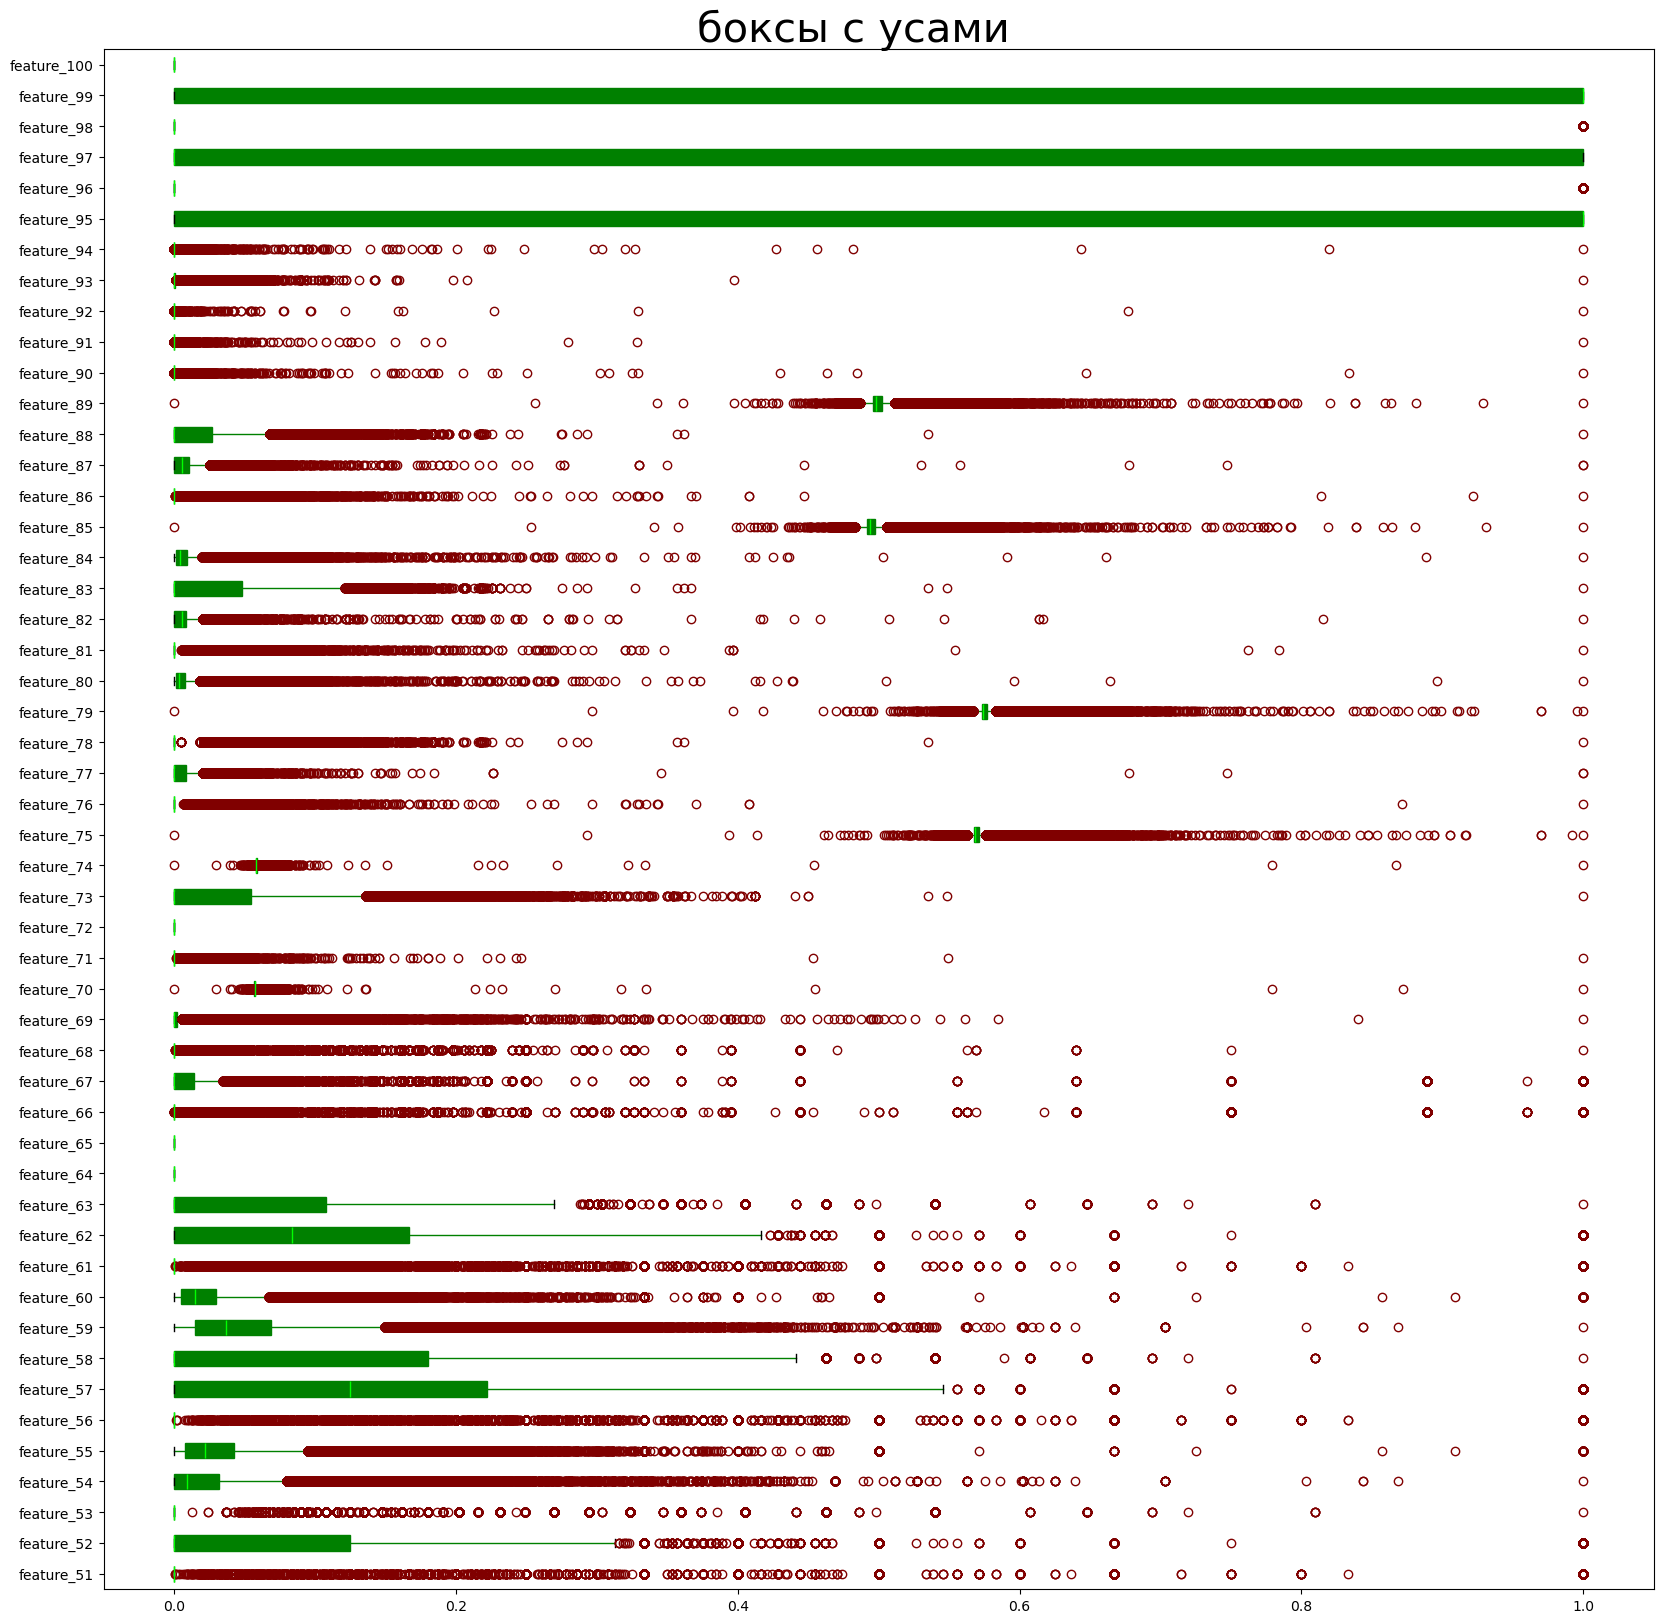

In [33]:
box(data_corr[['feature_51',
 'feature_52',
 'feature_53',
 'feature_54',
 'feature_55',
 'feature_56',
 'feature_57',
 'feature_58',
 'feature_59',
 'feature_60',
 'feature_61',
 'feature_62',
 'feature_63',
 'feature_64',
 'feature_65',
 'feature_66',
 'feature_67',
 'feature_68',
 'feature_69',
 'feature_70',
 'feature_71',
 'feature_72',
 'feature_73',
 'feature_74',
 'feature_75',
 'feature_76',
 'feature_77',
 'feature_78',
 'feature_79',
 'feature_80',
 'feature_81',
 'feature_82',
 'feature_83',
 'feature_84',
 'feature_85',
 'feature_86',
 'feature_87',
 'feature_88',
 'feature_89',
 'feature_90',
 'feature_91',
 'feature_92',
 'feature_93',
 'feature_94',
 'feature_95',
 'feature_96',
 'feature_97',
 'feature_98',
 'feature_99',
 'feature_100']])

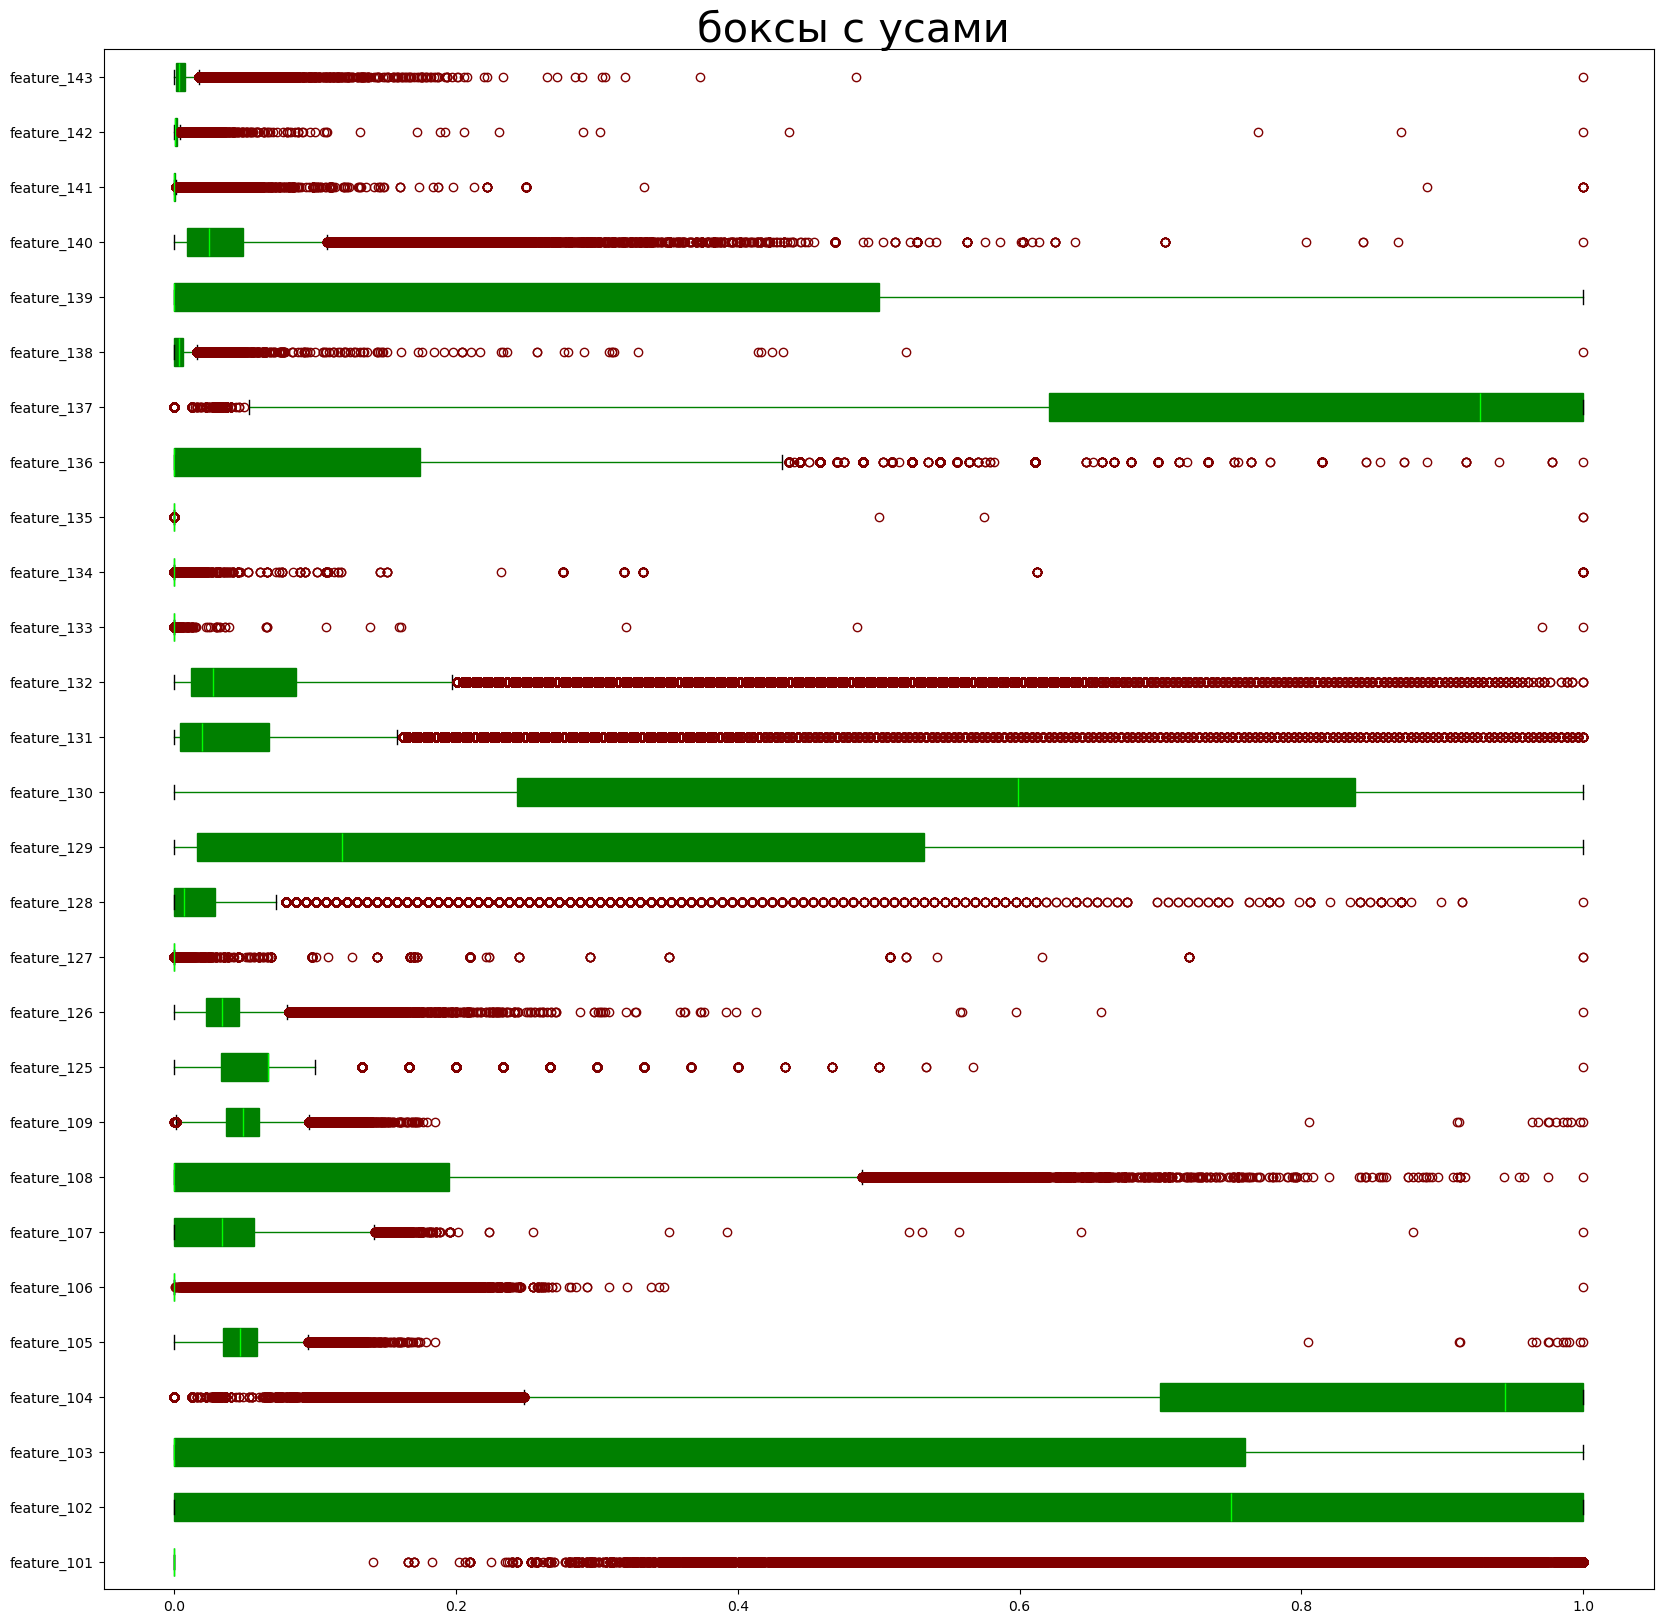

In [34]:
box(data_corr[['feature_101',
 'feature_102',
 'feature_103',
 'feature_104',
 'feature_105',
 'feature_106',
 'feature_107',
 'feature_108',
 'feature_109',
 'feature_125',
 'feature_126',
 'feature_127',
 'feature_128',
 'feature_129',
 'feature_130',
 'feature_131',
 'feature_132',
 'feature_133',
 'feature_134',
 'feature_135',
 'feature_136',
 'feature_137',
 'feature_138',
 'feature_139',
 'feature_140',
 'feature_141',
 'feature_142',
 'feature_143']])

Выбросы имеем везде, кроме некоторых фичей. Выпишем их в отдельный список.

In [35]:
list_features = ['feature_20', 'feature_35', 'feature_64', 'feature_65', 'feature_72', 'feature_87', 'feature_95',
                'feature_97', 'feature_99', 'feature_102', 'feature_103', 'feature_129', 'feature_130', 'query_id', 'rank']


In [36]:
# Для нашей функции, которая борется с выбросами, выпишем фичи, в которых имеем выбросы
features_for_iqr = data_corr.drop(list_features, axis=1).columns.values.tolist()

In [37]:
iqr(data_corr, features_for_iqr)

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143,rank,query_id
3,0.096774,0.0,0.111111,0.0,0.096774,1.0,0.0,1.0,0.000013,1.0,...,0.0,0.975355,0.007277,0.0,0.074712,0.001020,0.000531,0.001718,1,0
14,0.096774,0.0,0.111111,0.0,0.096774,1.0,0.0,1.0,0.000060,1.0,...,0.0,0.975551,0.007277,0.0,0.041761,0.000124,0.001592,0.005155,0,0
19,0.096774,0.0,0.111111,0.0,0.096774,1.0,0.0,1.0,0.000081,1.0,...,0.0,0.947973,0.007277,0.0,0.025505,0.000048,0.000332,0.001074,1,0
21,0.096774,0.0,0.111111,0.0,0.096774,1.0,0.0,1.0,0.000089,1.0,...,0.0,0.969151,0.007277,0.0,0.022393,0.000080,0.000730,0.002363,2,0
28,0.096774,0.0,0.000000,0.0,0.096774,1.0,0.0,0.0,0.000119,1.0,...,0.0,0.975608,0.000000,0.0,0.030564,0.000156,0.000597,0.001933,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235165,0.064516,0.0,0.000000,0.0,0.064516,1.0,0.0,0.0,0.999609,1.0,...,0.0,1.000000,0.000000,0.0,0.001870,0.000000,0.000133,0.000644,0,1998
235166,0.064516,0.0,0.000000,0.0,0.064516,1.0,0.0,0.0,0.999613,1.0,...,0.0,1.000000,0.000000,0.0,0.002176,0.000000,0.000133,0.000644,0,1998
235167,0.064516,0.0,0.074074,0.0,0.064516,1.0,0.0,1.0,0.999617,1.0,...,0.0,0.971415,0.006944,0.0,0.031079,0.000120,0.001260,0.006121,0,1998
235171,0.064516,0.0,0.000000,0.0,0.064516,1.0,0.0,0.0,0.999634,1.0,...,0.0,0.723515,0.000000,0.0,0.024566,0.000632,0.000862,0.004188,1,1998


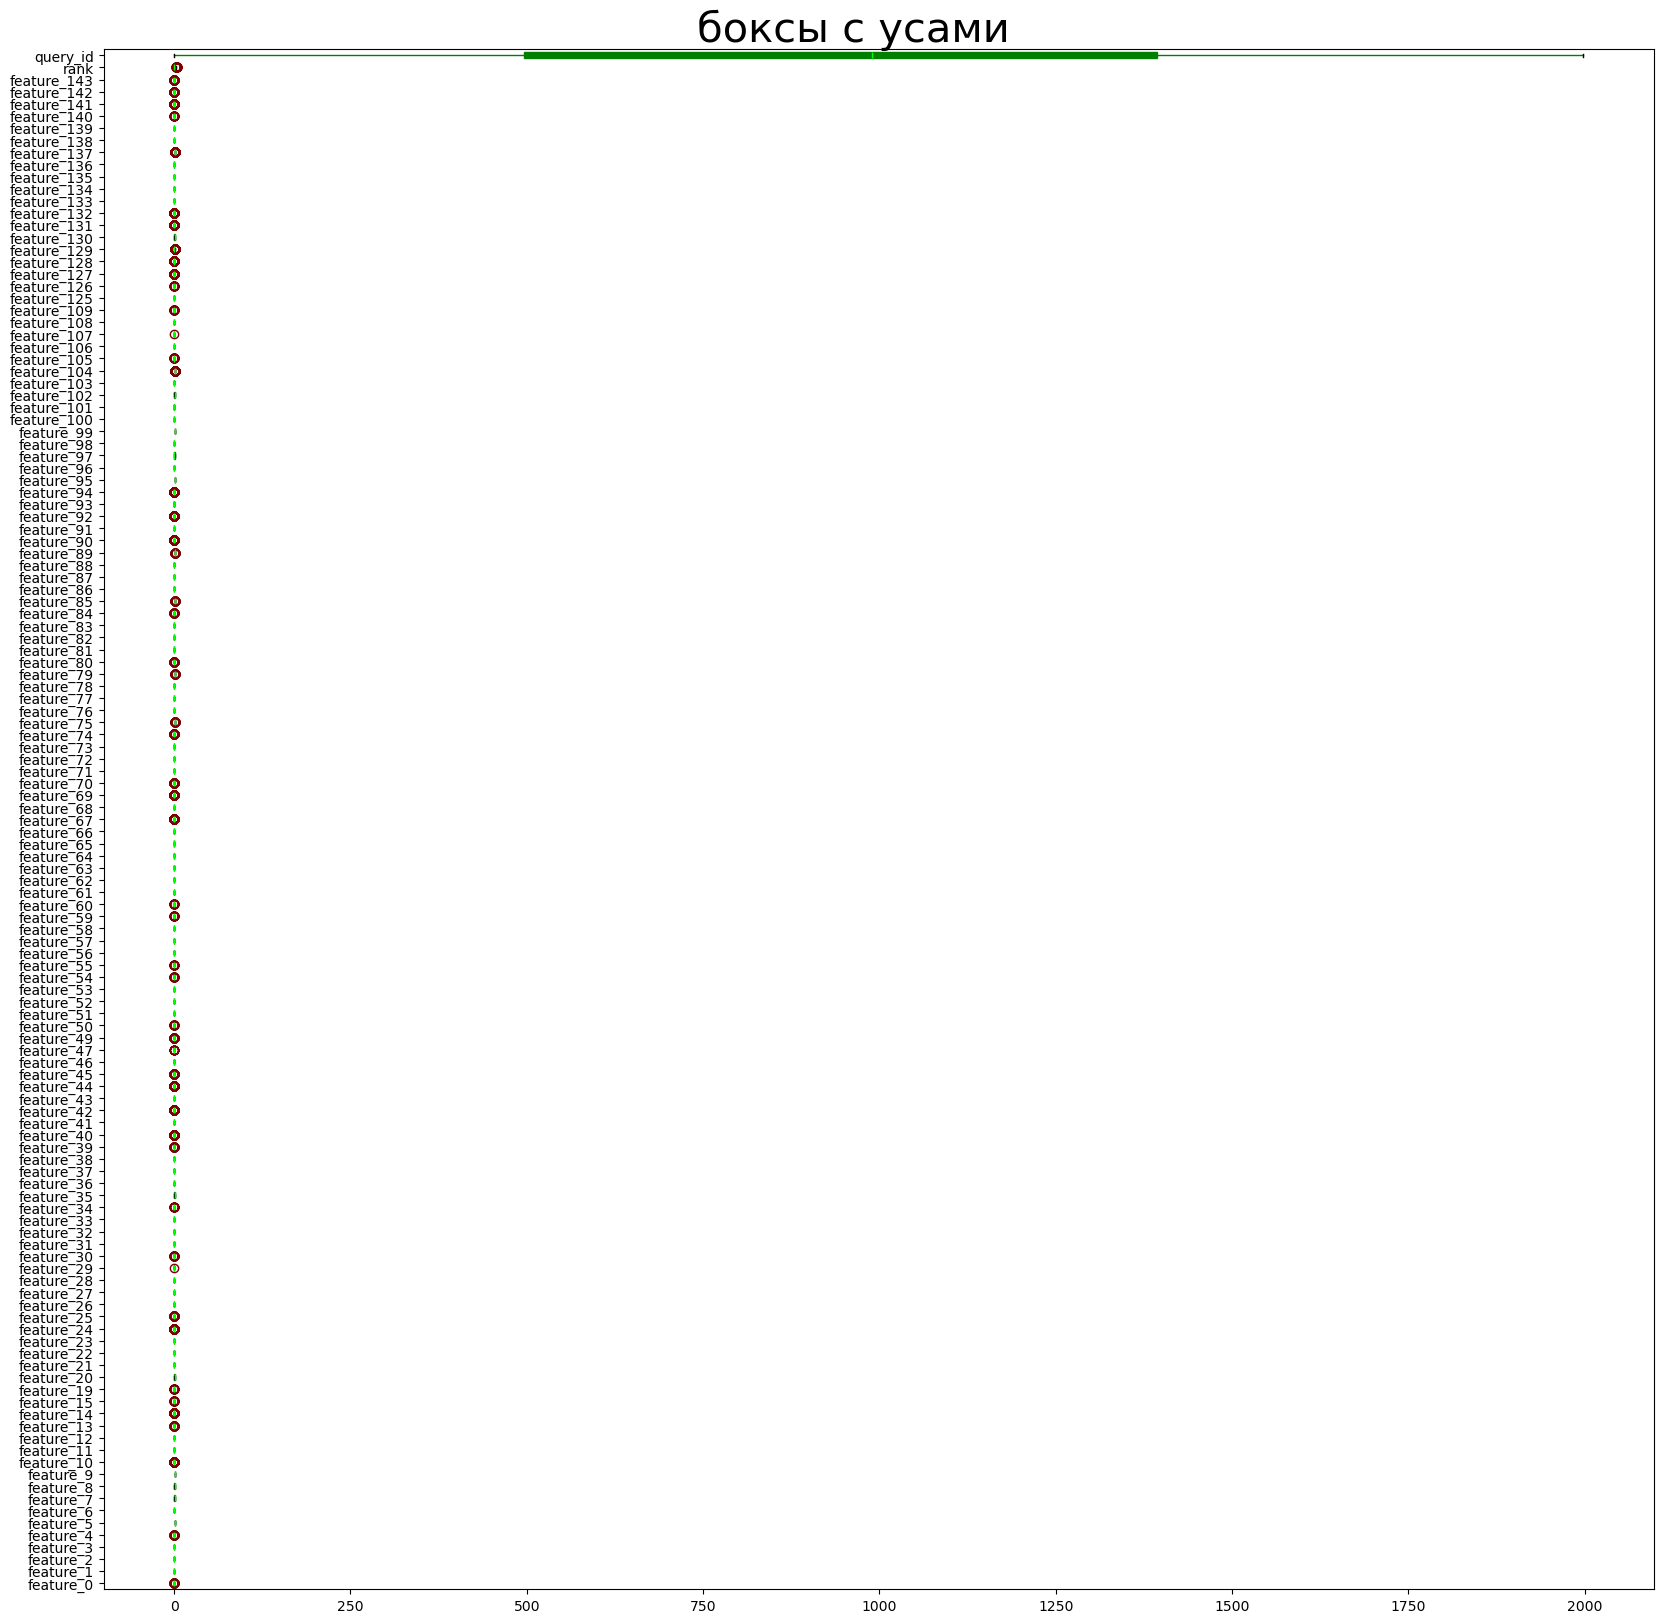

In [38]:
#Посмотрим, остались ли выбросы
data_iqr = iqr(data_corr, features_for_iqr)
box(data_iqr)

Еще выбросы есть, прогоним функцию iqr еще раз для фичей с выбросами

In [39]:
features_for_iqr_2 = ['feature_0', 'feature_4', 'feature_10', 'feature_13', 'feature_14', 'feature_15', 'feature_19',
                'feature_24', 'feature_25', 'feature_29', 'feature_30', 'feature_34', 'feature_39', 'feature_40', 'feature_42',
                    'feature_44', 'feature_45', 'feature_47', 'feature_49', 'feature_50', 'feature_54', 'feature_55',
                     'feature_59', 'feature_60', 'feature_67', 'feature_69', 'feature_70', 'feature_74', 'feature_75',
                     'feature_79', 'feature_80', 'feature_84', 'feature_85', 'feature_89', 'feature_90', 'feature_92',
                     'feature_94', 'feature_103', 'feature_105', 'feature_107', 'feature_109', 'feature_126', 'feature_127',
                     'feature_128', 'feature_129', 'feature_131', 'feature_132', 'feature_137', 'feature_140', 'feature_141',
                     'feature_142', 'feature_143']

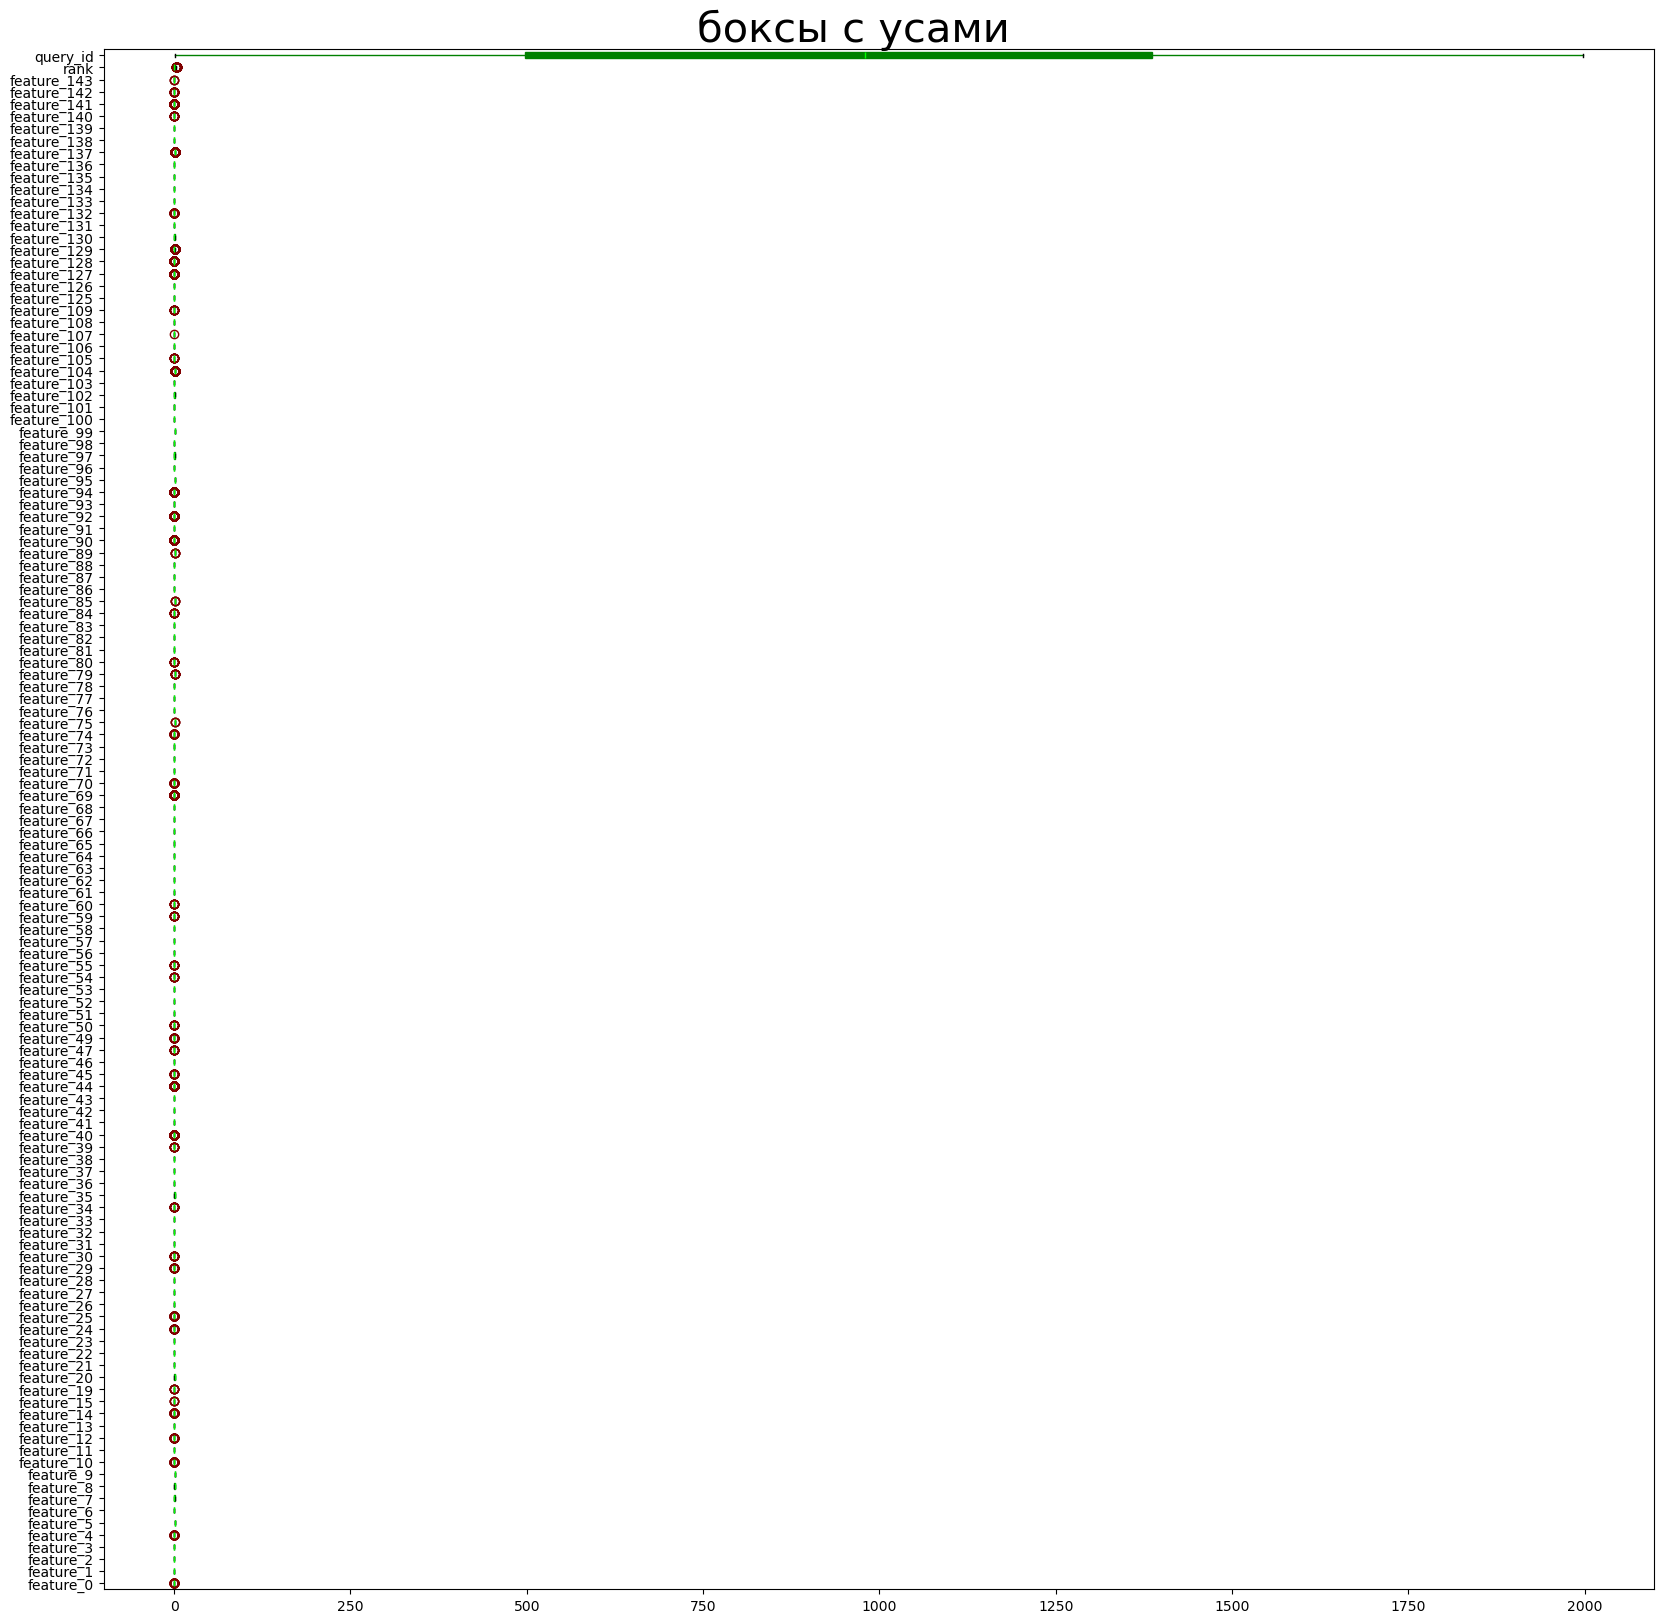

In [40]:
data_iqr = iqr(data_iqr, features_for_iqr_2)
box(data_iqr)

Особо сильных изменений не видим. Посмотрим на пропущенные значения

In [41]:
#Пропущенные значения в датасете с выбросами
data_corr.isnull().sum()

feature_0        731
feature_1      32237
feature_2        182
feature_3       5981
feature_4        742
               ...  
feature_141    60555
feature_142    23415
feature_143    23985
rank               0
query_id           0
Length: 127, dtype: int64

In [42]:
# В датасете без выбросов
data_iqr.isnull().sum()

feature_0      0
feature_1      0
feature_2      0
feature_3      0
feature_4      0
              ..
feature_141    0
feature_142    0
feature_143    0
rank           0
query_id       0
Length: 127, dtype: int64

In [43]:
# удалим пропуски в датасете с выбросами
data_corr = data_corr.dropna()
data_corr.isnull().sum()

feature_0      0
feature_1      0
feature_2      0
feature_3      0
feature_4      0
              ..
feature_141    0
feature_142    0
feature_143    0
rank           0
query_id       0
Length: 127, dtype: int64

# Модели

В данном разделе хотелось бы посмотреть, как работают модели ранжирования с различными данными. То есть прогоним модели по данным с выбросами и без них.

Делим данные с использованием query_id. Это гарантирует, что все документы, связанные с одним запросом, будут либо в тренировочном, либо в тестовом наборе данных, а не разделены между ними. Для начала отсортируем данные по query_id, далее разделим с помощью train_test_split, где уберем перемешивание.

## Модели на "сырых" данных

### Тренировочный / тестовый набор

In [44]:
# Получение уникальных query_id
unique_query_ids_0 = data['query_id'].unique()

In [45]:
# Случайное разделение query_id на тренировочный и тестовый наборы
train_query, test_query = train_test_split(unique_query_ids_0, test_size=0.2, random_state=42)

In [46]:
# Фильтрация данных по разделенным query_id
train_data_0 = data[data['query_id'].isin(train_query)]
test_data_0 = data[data['query_id'].isin(test_query)]

In [47]:
# Выделим целевой признак
y_train_0 = train_data_0['rank']
y_test_0 = test_data_0['rank']
X_train_0 = train_data_0.drop(columns='rank')
X_test_0 = test_data_0.drop(columns='rank')

In [48]:
#Проверяем размерность получившихся выборок
print(X_train_0.shape)
print(X_test_0.shape)

print(y_train_0.shape)
print(y_test_0.shape)

(188989, 145)
(46269, 145)
(188989,)
(46269,)


### Линейная регрессия

In [49]:
model_reg_0 = LinearRegression()
model_reg_0.fit(X_train_0, y_train_0)

LinearRegression()

In [50]:
# Сделаем предикт
predictions_reg_0 = model_reg_0.predict(X_test_0)

In [51]:
mse_0 = mean_squared_error(y_test_0, predictions_reg_0)
mse_0

0.5884801653982327

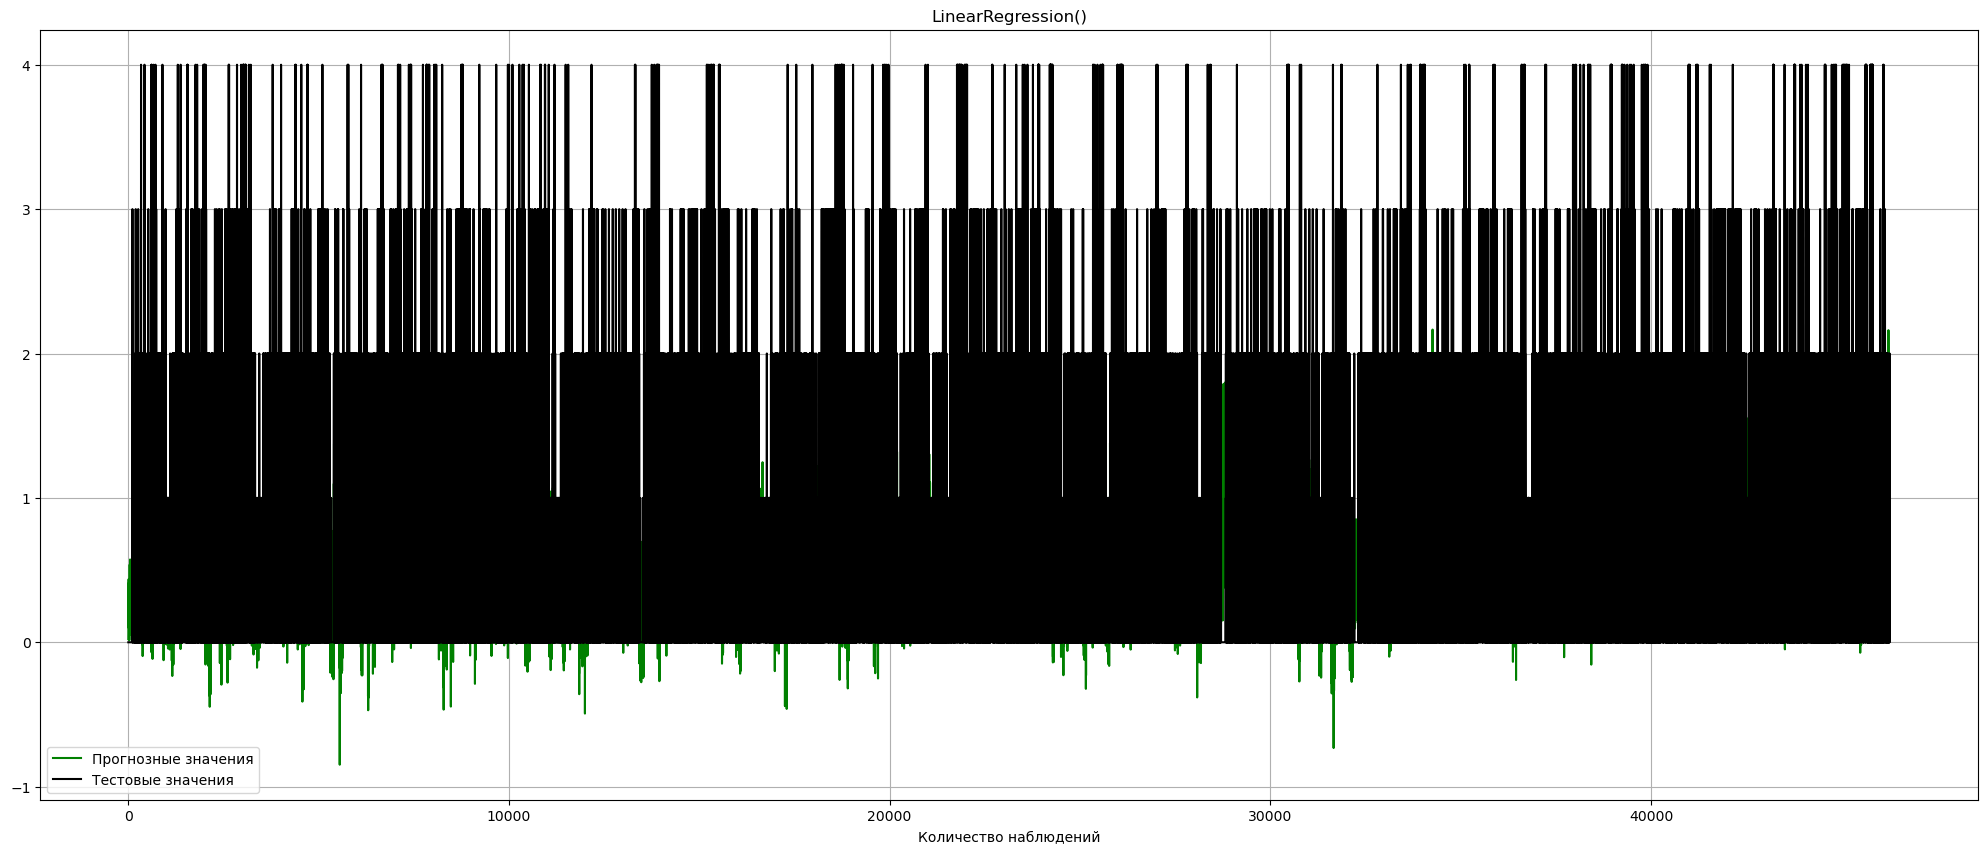

In [52]:
  plt.figure(figsize = (25, 10))
  plt.title(model_reg_0)
  plt.plot(predictions_reg_0, label="Прогнозные значения", color='green')
  plt.plot(y_test_0.values, label="Тестовые значения", color='black')
  plt.xlabel('Количество наблюдений')
  plt.grid(True)
  plt.legend()

### XGBoost

In [53]:
# Определение модели
model_12 = xgb.XGBClassifier(
    learning_rate=0.1,
    n_estimators=100,
    max_depth=3
)


In [54]:
# Обучение модели
model_12.fit(X_train_0, y_train_0)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [55]:
# Предсказание на тестовом наборе данных
predictions_12 = model_12.predict(X_test_0)

In [56]:
# Оценка качества модели
accuracy_12 = accuracy_score(y_test_0, predictions_12)
accuracy_12

0.562147442131881

In [57]:
# напишем функцию для ndcg

def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum((2 ** r - 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.

def ndcg_at_k(actual_relevances, predicted_rankings, k):
    dcg_max = dcg_at_k(sorted(actual_relevances, reverse=True), k)
    if not dcg_max:
        return 0.
    return dcg_at_k(actual_relevances, k) / dcg_max

In [58]:
print("NDCG@5:", ndcg_at_k(y_test_0, predictions_12, 100))

NDCG@5: 0.0


## Модели для данных с выбросами

### Тренировочный / тестовый наборы

In [59]:
# Получение уникальных query_id
unique_query_ids = data_corr['query_id'].unique()

In [60]:
# Случайное разделение query_id на тренировочный и тестовый наборы
train_query_ids, test_query_ids = train_test_split(unique_query_ids, test_size=0.2, random_state=42)

In [61]:
# Фильтрация данных по разделенным query_id
train_data = data_corr[data_corr['query_id'].isin(train_query_ids)]
test_data = data_corr[data_corr['query_id'].isin(test_query_ids)]

In [62]:
train_data

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143,rank,query_id
14,0.096774,0.0,0.111111,0.0,0.096774,1.0,0.0,1.0,0.000060,1.0,...,0.0,0.975551,0.007277,0.0,0.041761,0.000124,0.001592,0.005155,0,0
19,0.096774,0.0,0.111111,0.0,0.096774,1.0,0.0,1.0,0.000081,1.0,...,0.0,0.947973,0.007277,0.0,0.025505,0.000048,0.000332,0.001074,1,0
28,0.096774,0.0,0.000000,0.0,0.096774,1.0,0.0,0.0,0.000119,1.0,...,0.0,0.975608,0.000000,0.0,0.030564,0.000156,0.000597,0.001933,1,0
45,0.096774,0.0,0.111111,0.0,0.096774,1.0,0.0,1.0,0.000191,1.0,...,0.0,0.998916,0.007277,0.0,0.059109,0.000088,0.000730,0.002363,1,0
55,0.096774,0.0,0.000000,0.0,0.096774,1.0,0.0,0.0,0.000234,1.0,...,0.0,0.897563,0.000000,0.0,0.034858,0.000340,0.001194,0.003866,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235086,0.032258,0.0,0.000000,0.0,0.032258,1.0,0.0,0.0,0.999273,1.0,...,0.0,1.000000,0.000000,0.0,0.002608,0.000000,0.000133,0.001289,1,1997
235092,0.032258,0.0,0.000000,0.0,0.032258,1.0,0.0,0.0,0.999299,1.0,...,0.0,1.000000,0.000000,0.0,0.003239,0.000000,0.000066,0.000644,0,1997
235129,0.064516,0.0,0.000000,0.0,0.064516,1.0,0.0,0.0,0.999456,1.0,...,0.0,1.000000,0.000000,0.0,0.014494,0.000000,0.000133,0.000644,0,1998
235165,0.064516,0.0,0.000000,0.0,0.064516,1.0,0.0,0.0,0.999609,1.0,...,0.0,1.000000,0.000000,0.0,0.001870,0.000000,0.000133,0.000644,0,1998


In [63]:
test_data

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143,rank,query_id
3740,0.129032,0.0,0.000000,0.0,0.129032,1.0,0.0,0.0,0.015898,1.0,...,0.0,0.644759,0.000000,0.0,0.011716,0.000280,0.000995,0.002416,0,34
4498,0.064516,0.0,0.000000,0.0,0.064516,1.0,0.0,0.0,0.019120,1.0,...,0.0,0.996485,0.000000,0.0,0.046028,0.000040,0.000730,0.003544,0,42
4521,0.064516,0.0,0.074074,0.0,0.064516,1.0,0.0,1.0,0.019217,1.0,...,0.0,0.973860,0.004802,0.0,0.022810,0.000080,0.001327,0.006443,0,42
4525,0.064516,0.0,0.074074,0.0,0.064516,1.0,0.0,1.0,0.019234,1.0,...,0.0,1.000000,0.004802,0.0,0.017797,0.000000,0.000531,0.002577,1,42
4553,0.064516,0.0,0.000000,0.0,0.064516,1.0,0.0,0.0,0.019353,1.0,...,0.0,0.959975,0.000000,0.0,0.021303,0.000080,0.000929,0.004510,1,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233625,0.129032,0.0,0.000000,0.0,0.129032,1.0,0.0,0.0,0.993063,1.0,...,0.0,1.000000,0.000000,0.0,0.001306,0.000000,0.000265,0.000644,1,1980
233718,0.096774,0.0,0.000000,0.0,0.096774,1.0,0.0,0.0,0.993458,1.0,...,0.0,0.969486,0.000000,0.0,0.018148,0.000036,0.001128,0.003651,1,1981
233750,0.096774,0.0,0.000000,0.0,0.096774,1.0,0.0,0.0,0.993594,1.0,...,0.0,0.969486,0.000000,0.0,0.017864,0.000032,0.001128,0.003651,0,1981
234298,0.129032,0.0,0.148148,0.0,0.129032,1.0,0.0,1.0,0.995924,1.0,...,0.0,0.934245,0.012104,0.0,0.020294,0.000136,0.001393,0.003383,1,1989


Видим, что разделение прошло успешно.

In [64]:
# Выделим целевой признак
y_train = train_data['rank']
y_test = test_data['rank']
X_train = train_data.drop(columns='rank')
X_test = test_data.drop(columns='rank')

In [65]:
#Проверяем размерность получившихся выборок
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(4468, 126)
(1167, 126)
(4468,)
(1167,)


### Линейная регрессия

In [66]:
model_reg = LinearRegression()
model_reg.fit(X_train, y_train)

LinearRegression()

In [67]:
# Сделаем предикт
predictions_reg = model_reg.predict(X_test)

In [68]:
mse = mean_squared_error(y_test, predictions_reg)

In [69]:
mse

0.43430364141362376

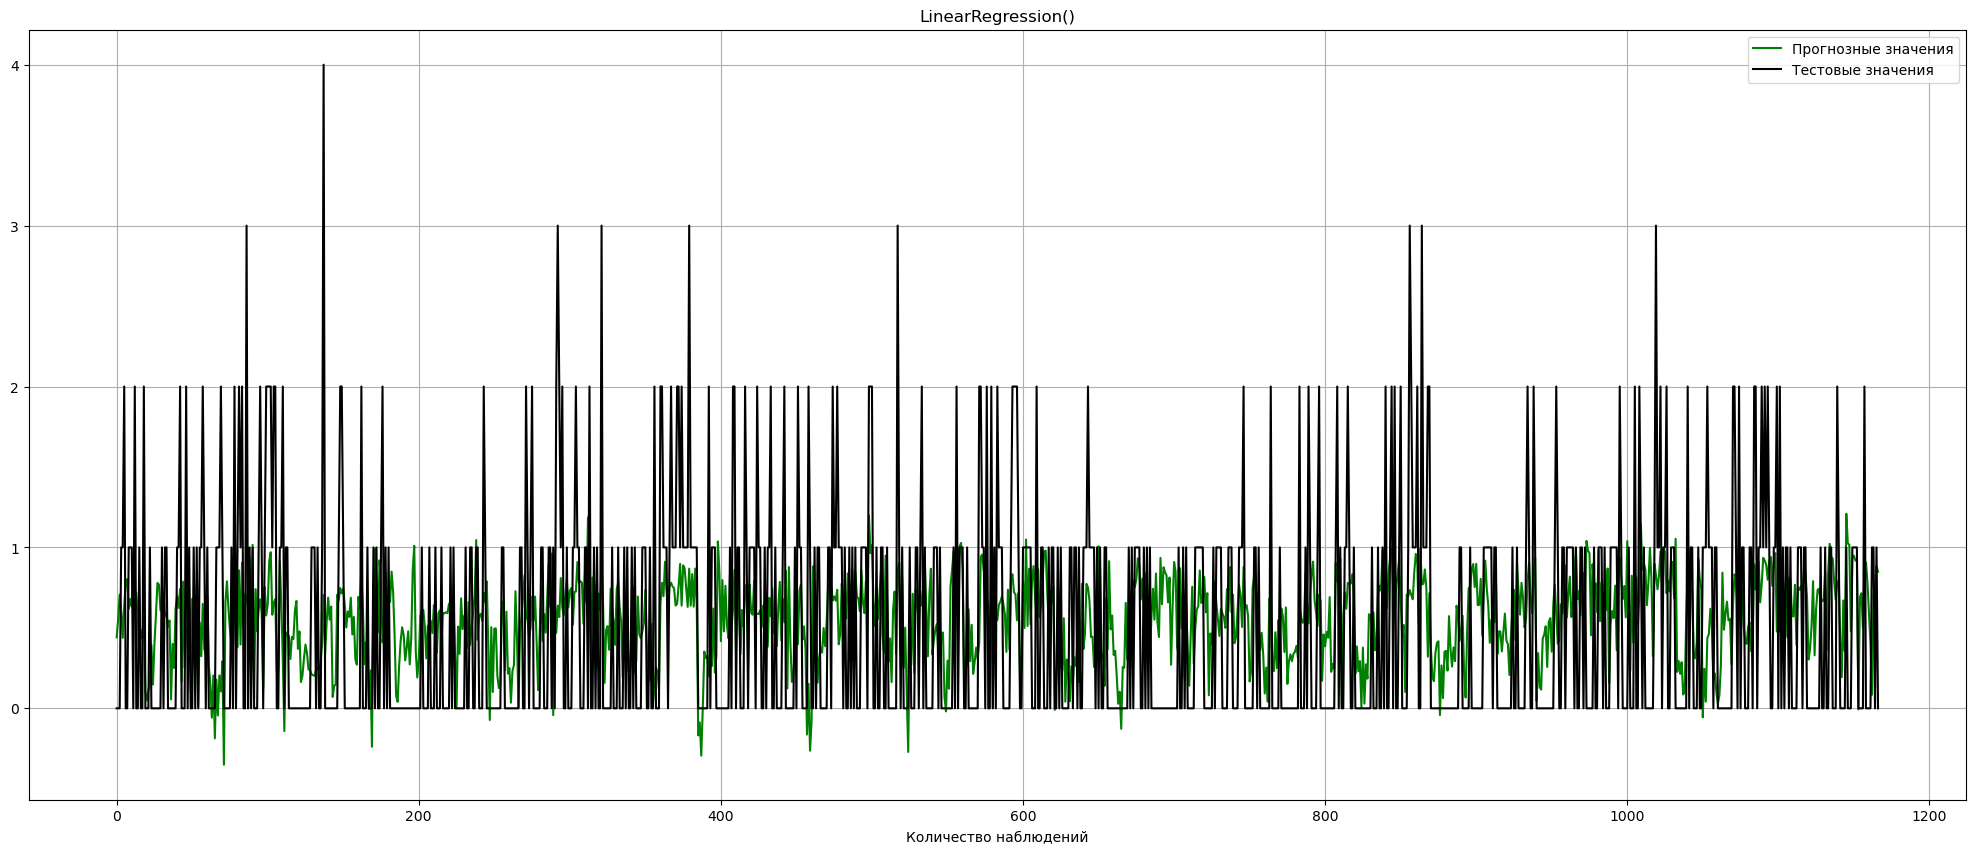

In [70]:
  plt.figure(figsize = (25, 10))
  plt.title(model_reg)
  plt.plot(predictions_reg, label="Прогнозные значения", color='green')
  plt.plot(y_test.values, label="Тестовые значения", color='black')
  plt.xlabel('Количество наблюдений')
  #plt.ylabel(y_train)
  plt.grid(True)
  plt.legend()

Результат чуть лучше, чем на "сырых" данных.

### Xgboost

In [71]:
# Определение модели
model_22 = xgb.XGBClassifier(
    learning_rate=0.1,
    n_estimators=100,
    max_depth=3
)

In [72]:
# Обучение модели
model_22.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [73]:
# Предсказание на тестовом наборе данных
predictions_22 = model_22.predict(X_test)

In [74]:
# Оценка качества модели
accuracy_22 = accuracy_score(y_test, predictions_22)
accuracy_22

0.6015424164524421

In [75]:
print("NDCG@5:", ndcg_at_k(y_test, predictions_22, 5))

NDCG@5: 0.02854580332055146


## Модели на данных без выбросов

### Тренировочный / тестовый сплит

In [76]:
# Получение уникальных query_id
unique_query_iqr = data_iqr['query_id'].unique()

In [77]:
# Случайное разделение query_id на тренировочный и тестовый наборы
train_query_iqr, test_query_iqr = train_test_split(unique_query_iqr, test_size=0.2, random_state=42)

In [78]:
# Фильтрация данных по разделенным query_id
train_data_iqr = data_iqr[data_iqr['query_id'].isin(train_query_iqr)]
test_data_iqr = data_iqr[data_iqr['query_id'].isin(test_query_iqr)]

In [79]:
train_data_iqr

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143,rank,query_id
98,0.096774,0.0,0.000000,0.0,0.096774,1.0,0.0,0.0,0.000417,1.0,...,0.0,0.973570,0.000000,0.0,0.007589,0.000016,0.000265,0.000859,0,1
341,0.096774,0.0,0.111111,0.0,0.096774,1.0,0.0,1.0,0.001449,1.0,...,0.0,1.000000,0.009153,0.0,0.023830,0.000000,0.000199,0.000644,0,4
664,0.064516,0.0,0.074074,0.0,0.064516,1.0,0.0,1.0,0.002822,1.0,...,0.0,1.000000,0.005680,0.0,0.033878,0.000000,0.000398,0.001933,0,7
665,0.064516,0.0,0.074074,0.0,0.064516,1.0,0.0,1.0,0.002827,1.0,...,0.0,1.000000,0.005680,0.0,0.027299,0.000000,0.000398,0.001933,1,7
668,0.064516,0.0,0.000000,0.0,0.064516,1.0,0.0,0.0,0.002839,1.0,...,0.0,0.993810,0.000000,0.0,0.011893,0.000004,0.000597,0.002899,1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233803,0.064516,0.0,0.074074,0.0,0.064516,1.0,0.0,1.0,0.993820,1.0,...,0.0,0.996201,0.005538,0.0,0.020960,0.000004,0.000730,0.003544,0,1983
233854,0.064516,0.0,0.074074,0.0,0.064516,1.0,0.0,1.0,0.994036,1.0,...,0.0,0.994385,0.005538,0.0,0.013687,0.000004,0.000597,0.002899,1,1983
234970,0.064516,0.0,0.074074,0.0,0.064516,1.0,0.0,1.0,0.998780,1.0,...,0.0,0.998028,0.005542,0.0,0.039055,0.000028,0.000597,0.002899,0,1996
235092,0.032258,0.0,0.000000,0.0,0.032258,1.0,0.0,0.0,0.999299,1.0,...,0.0,1.000000,0.000000,0.0,0.003239,0.000000,0.000066,0.000644,0,1997


In [80]:
test_data_iqr

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143,rank,query_id
538,0.096774,0.0,0.000000,0.0,0.096774,1.0,0.0,0.0,0.002287,1.0,...,0.0,1.000000,0.000000,0.0,0.019086,0.000000,0.000597,0.001933,0,5
2050,0.096774,0.0,0.000000,0.0,0.096774,1.0,0.0,0.0,0.008714,1.0,...,0.0,0.938417,0.000000,0.0,0.011054,0.000092,0.000332,0.001074,0,19
3307,0.032258,0.0,0.000000,0.0,0.032258,1.0,0.0,0.0,0.014057,1.0,...,0.0,1.000000,0.000000,0.0,0.004339,0.000000,0.000066,0.000644,0,29
7953,0.064516,0.0,0.074074,0.0,0.064516,1.0,0.0,1.0,0.033806,1.0,...,0.0,0.994668,0.005507,0.0,0.042748,0.000052,0.000464,0.002255,1,71
8027,0.064516,0.0,0.074074,0.0,0.064516,1.0,0.0,1.0,0.034120,1.0,...,0.0,0.998724,0.005507,0.0,0.017971,0.000004,0.000995,0.004832,0,71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233171,0.064516,0.0,0.000000,0.0,0.064516,1.0,0.0,0.0,0.991133,1.0,...,0.0,1.000000,0.000000,0.0,0.014060,0.000000,0.000133,0.000644,0,1976
234139,0.032258,0.0,0.000000,0.0,0.032258,1.0,0.0,0.0,0.995248,1.0,...,0.0,1.000000,0.000000,0.0,0.003380,0.000000,0.000066,0.000644,0,1987
234145,0.032258,0.0,0.037037,0.0,0.032258,1.0,0.0,1.0,0.995273,1.0,...,0.0,1.000000,0.005812,0.0,0.022083,0.000000,0.000133,0.001289,2,1987
234177,0.032258,0.0,0.000000,0.0,0.032258,1.0,0.0,0.0,0.995409,1.0,...,0.0,1.000000,0.000000,0.0,0.001610,0.000000,0.000066,0.000644,1,1987


In [81]:
# Выделим целевой признак
y_train_iqr = train_data_iqr['rank']
y_test_iqr = test_data_iqr['rank']
X_train_iqr = train_data_iqr.drop(columns='rank')
X_test_iqr = test_data_iqr.drop(columns='rank')

In [82]:
#Проверяем размерность получившихся выборок
print(X_train_iqr.shape)
print(X_test_iqr.shape)

print(y_train_iqr.shape)
print(y_test_iqr.shape)

(1490, 126)
(397, 126)
(1490,)
(397,)


### Линейная регрессия

In [83]:
model_reg_iqr = LinearRegression()
model_reg_iqr.fit(X_train_iqr, y_train_iqr)

LinearRegression()

In [84]:
# Сделаем предикт
predictions_reg_iqr = model_reg_iqr.predict(X_test_iqr)

In [85]:
mse_iqr = mean_squared_error(y_test_iqr, predictions_reg_iqr)
mse_iqr

0.5049044791748127

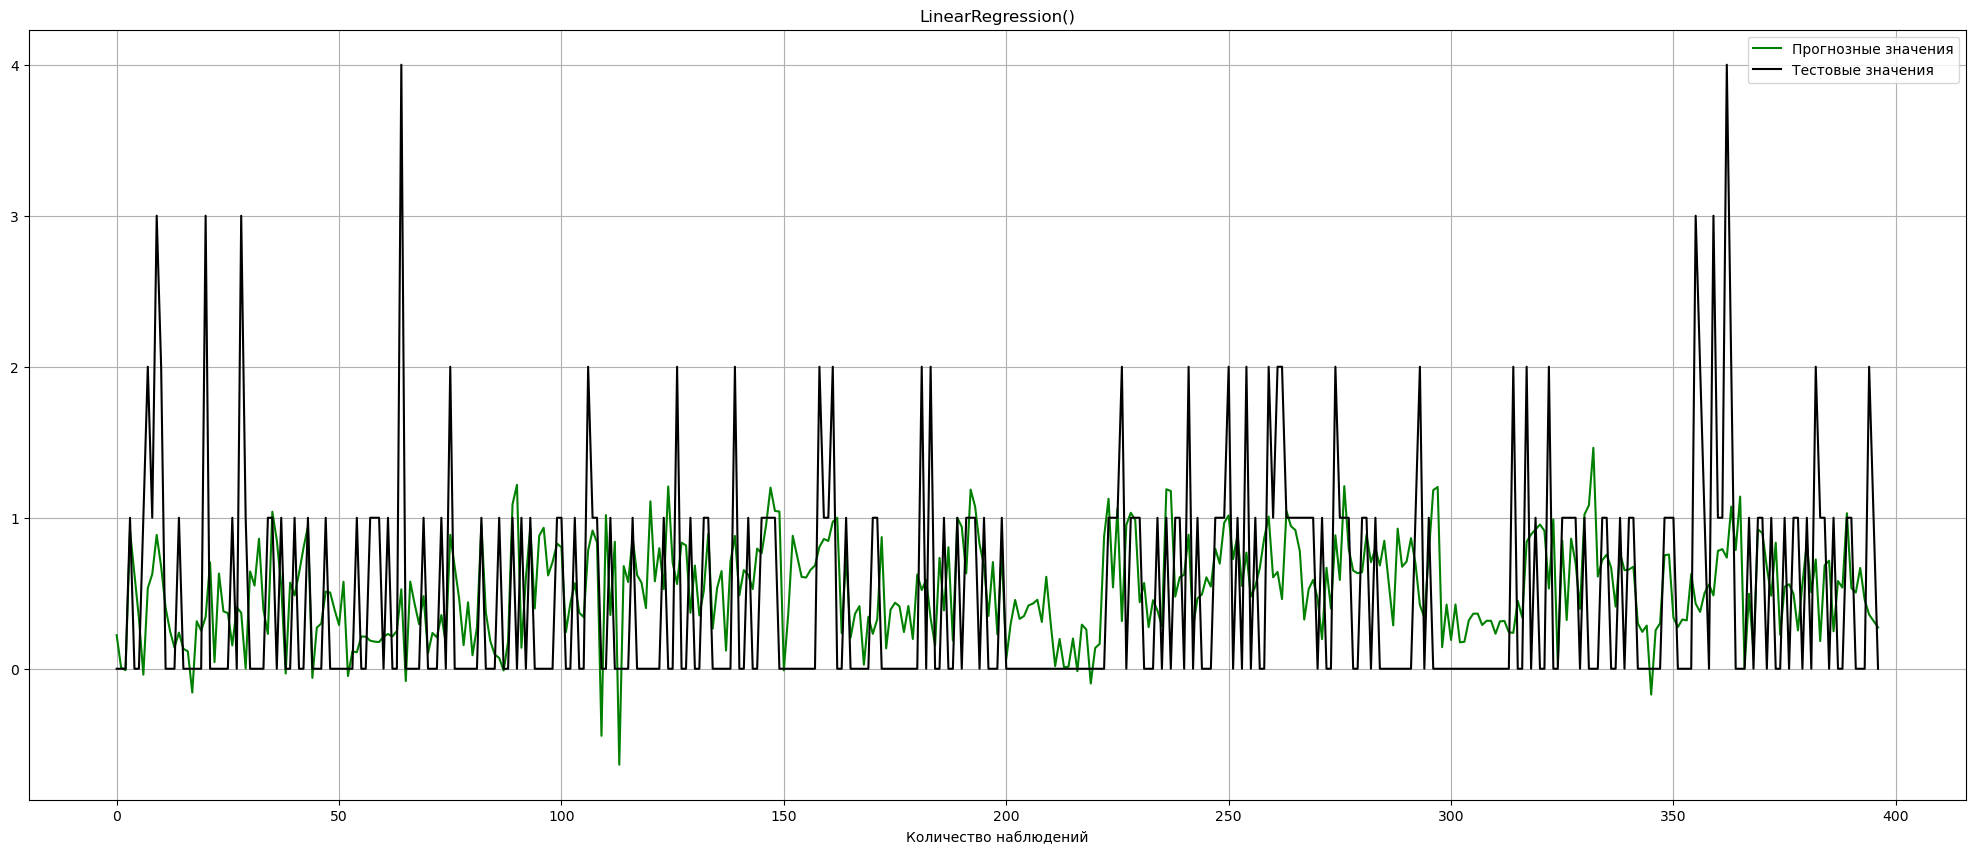

In [86]:
  plt.figure(figsize = (25, 10))
  plt.title(model_reg_iqr)
  plt.plot(predictions_reg_iqr, label="Прогнозные значения", color='green')
  plt.plot(y_test_iqr.values, label="Тестовые значения", color='black')
  plt.xlabel('Количество наблюдений')
  plt.grid(True)
  plt.legend()

### XGBoost

In [87]:
# Определение модели
model_32 = xgb.XGBClassifier(
    learning_rate=0.1,
    n_estimators=100,
    max_depth=3
)

In [88]:
# Обучение модели
model_32.fit(X_train_iqr, y_train_iqr)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [89]:
# Предсказание на тестовом наборе данных
predictions_32 = model_32.predict(X_test_iqr)

In [90]:
# Оценка качества модели
accuracy_32 = accuracy_score(y_test_iqr, predictions_32)
accuracy_32

0.6423173803526449

In [91]:
print("NDCG@5:", ndcg_at_k(y_test_iqr, predictions_32, 5))

NDCG@5: 0.012784783713559988


# Вывод

Мне не удалось построить хорошую модель для выставления релевантности документам, но резюмируя проделанную работу, могу сказать, что лучший результат показала модель без удаления выбросов (XGBoost). Линейная регрессия не показала однозначных результатов. Для улучшения можно еще подчистить коррелирующие признаки (их довольно много), далее можно использовать другие модели, например, RankNet и RankBoost, использовать поиск по сетке для выявления наиболее успешных параметров, а также применить кроссвалидацию.